# Introduction

Ever wondered who are your best customers? Who spends the most in your company? Who are the loyal customers?

These questions are answered by a RFM Analysis. RFM stands for Recency, Monetary, and Frequency. RFM analysis is a marketing analysis tool used to identify customer's activity in a particular business. RFM analysis is based on the factors shown in the image below.

![RFM Factors](https://d35fo82fjcw0y8.cloudfront.net/2018/03/01013508/Incontent_image.png)

In this notebook, I will be discussing a data scientist approach in applying RFM analysis. 

## Importing Libraries & Defining helper functions

In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from glob import glob
path = '/kaggle/input' if len(glob('/kaggle/input/*/*')) > 0 else 'data_input/'
path += os.listdir(path)[0] + '/'

import os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

data_input/brazilian-ecommerce/olist_geolocation_dataset.csv
data_input/brazilian-ecommerce/olist_order_reviews_dataset.csv
data_input/brazilian-ecommerce/product_category_name_translation.csv
data_input/brazilian-ecommerce/olist_order_payments_dataset.csv
data_input/brazilian-ecommerce/olist_sellers_dataset.csv
data_input/brazilian-ecommerce/olist_order_items_dataset.csv
data_input/brazilian-ecommerce/olist_customers_dataset.csv
data_input/brazilian-ecommerce/olist_products_dataset.csv
data_input/brazilian-ecommerce/olist_orders_dataset.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
!pip install pyspark

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("OLIST Data Preprocessing for RFM Analysis") \
    .getOrCreate()

In [4]:
def info(view,cols='*'):
    df = spark.sql(f'SELECT * FROM {view}')
    df_p = df.toPandas()
    size = df_p.shape
    print('dataframe name =',view)
    df.printSchema()
    print('dataframe size = ',size,end='\n\n')

    if cols == '*':
        cols = df_p.columns
    for col in cols:
        print(df_p[col].isna().sum(), f'\t null values in {col} feature')
        
def check_pk_isnull(view1,view2,pk1,pk2=None):
    if pk2==None:
        pk2=pk1
    return spark.sql(
        f'''
        SELECT DISTINCT {view1}.{pk1} AS df_{view1}, {view2}.{pk2} AS df_{view2}
        FROM {view1} FULL JOIN {view2} ON {view1}.{pk1} = {view2}.{pk2}
        WHERE ISNULL({view1}.{pk1}) = true or ISNULL({view2}.{pk2}) =true
        '''
    ).toPandas().tail()

# Loading Input Data and Data Cleaning

The loaded data will follow the schema below. ![Merging Schema](https://i.imgur.com/HRhd2Y0.png). Before merging each dataframe, there will be some quick data cleaning.

**Dataset 1: Product Category Name Translation**

About the dataset: Translates the product_category_name to english.

This dataset consist of the following features:

1. product_category_name: category name in Portuguese
2. product_category_name_english: category name in English

In [30]:
spark.read.csv(path + 'product_category_name_translation.csv',header=True).createOrReplaceTempView("product_category_translate")
info('product_category_translate')
spark.sql('SELECT * FROM product_category_translate').describe().show()
spark.sql('SELECT * FROM product_category_translate').toPandas().head()

dataframe name = product_category_translate
root
 |-- product_category_name: string (nullable = true)
 |-- product_category_name_english: string (nullable = true)

dataframe size =  (71, 2)

0 	 null values in product_category_name feature
0 	 null values in product_category_name_english feature
+-------+---------------------+-----------------------------+
|summary|product_category_name|product_category_name_english|
+-------+---------------------+-----------------------------+
|  count|                   71|                           71|
|   mean|                 null|                         null|
| stddev|                 null|                         null|
|    min| agro_industria_e_...|         agro_industry_and...|
|    max| utilidades_domest...|                watches_gifts|
+-------+---------------------+-----------------------------+



,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


**Dataset 2: Product Dataset**

About the dataset: This dataset includes data about the products sold by Olist.

This dataset consist of the following features:

1. product_id: unique product identifier
2. product_category_name: root category of product, in Portuguese.
3. product_name_lenght: number of characters extracted from the product name.
4. product_description_lenght: number of characters extracted from the product description.
5. product_photos_qty: number of product published photos
6. product_weight_g: product weight measured in grams.
7. product_length_cm: product length measured in centimeters.
8. product_height_cm: product height measured in centimeters.
9. product_width_cm: product width measured in centimeters.

In [31]:
spark.read.csv(path + 'olist_products_dataset.csv',header=True).createOrReplaceTempView("products")
info('products')
spark.sql('SELECT * FROM products').describe().show()
spark.sql('SELECT * FROM products').toPandas().head()

dataframe name = products
root
 |-- product_id: string (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: string (nullable = true)
 |-- product_description_lenght: string (nullable = true)
 |-- product_photos_qty: string (nullable = true)
 |-- product_weight_g: string (nullable = true)
 |-- product_length_cm: string (nullable = true)
 |-- product_height_cm: string (nullable = true)
 |-- product_width_cm: string (nullable = true)

dataframe size =  (32951, 9)

0 	 null values in product_id feature
610 	 null values in product_category_name feature
610 	 null values in product_name_lenght feature
610 	 null values in product_description_lenght feature
610 	 null values in product_photos_qty feature
2 	 null values in product_weight_g feature
2 	 null values in product_length_cm feature
2 	 null values in product_height_cm feature
2 	 null values in product_width_cm feature
+-------+--------------------+---------------------+------------------

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40,287,1,225,16,10,14
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44,276,1,1000,30,18,20
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46,250,1,154,18,9,15
3,cef67bcfe19066a932b7673e239eb23d,bebes,27,261,1,371,26,4,26
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37,402,4,625,20,17,13


Product Category Name Translation dataset will be used to translate the product category names to English. But before that, lets check whether all category names are available in the dataset

In [32]:
check_pk_isnull('products','product_category_translate','product_category_name')

,df_products,df_product_category_translate
0,pc_gamer,None
1,None,None
2,portateis_cozinha_e_preparadores_de_alimentos,None


Seems like there are several product names not translated. I will use google translate to help with that.

Besides of the name translations, notice that the datatype for all features loaded in PySpark are categorized as string. This can be problematic in the future and I will use the cast function to convert features with incorrect data type to the correct data type.

In [33]:
spark.sql(
    '''
    SELECT 
    products.product_id,
    CASE 
        WHEN products.product_category_name = 'pc_gamer' THEN 'pc_gamer'
        WHEN products.product_category_name = 'portateis_cozinha_e_preparadores_de_alimentos' THEN 'portable_cooking_and_food_prepareers'
        ELSE product_category_translate.product_category_name_english
    END product_category_name,
    CAST(products.product_name_lenght AS TINYINT),
    CAST(products.product_description_lenght AS SMALLINT),
    CAST(products.product_photos_qty AS TINYINT),
    CAST(products.product_weight_g AS INT),
    CAST(products.product_length_cm AS TINYINT),
    CAST(products.product_height_cm AS TINYINT),
    CAST(products.product_width_cm AS TINYINT)
    FROM products
    FULL JOIN product_category_translate 
    ON product_category_translate.product_category_name = products.product_category_name
    '''
).createOrReplaceTempView("products")
info('products')
spark.sql('SELECT * FROM products').describe().show()
spark.sql('SELECT * FROM products').toPandas().head()

dataframe name = products
root
 |-- product_id: string (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: byte (nullable = true)
 |-- product_description_lenght: short (nullable = true)
 |-- product_photos_qty: byte (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_length_cm: byte (nullable = true)
 |-- product_height_cm: byte (nullable = true)
 |-- product_width_cm: byte (nullable = true)

dataframe size =  (32951, 9)

0 	 null values in product_id feature
610 	 null values in product_category_name feature
610 	 null values in product_name_lenght feature
610 	 null values in product_description_lenght feature
610 	 null values in product_photos_qty feature
2 	 null values in product_weight_g feature
2 	 null values in product_length_cm feature
2 	 null values in product_height_cm feature
2 	 null values in product_width_cm feature
+-------+--------------------+---------------------+-------------------+--------

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e5428c428e0f783acd6e3d94ba4ee2a,computers,55.0,1067.0,1.0,12000.0,27.0,50.0,53.0
1,9aedf557945e816d48539ee56293f860,computers,55.0,3610.0,4.0,2400.0,16.0,31.0,39.0
2,a04087ab6a96ffa041f8a2701a72b616,computers,55.0,1105.0,1.0,13700.0,27.0,50.0,53.0
3,bc4cd4da98dd128c39bf0b8c2674032f,computers,55.0,3610.0,4.0,2650.0,16.0,31.0,39.0
4,194e74feac1f84a8ee5a517d4b3e107a,computers,59.0,3913.0,2.0,14150.0,52.0,27.0,52.0


**Dataset 3: Order Item Dataset**

About the dataset: This dataset includes data about the items purchased within each order.

This dataset consist of the following features:

1. order_id: order unique identifier
2. order_item_id: sequential number identifying number of items included in the same order.
3. product_id: product unique identifier
4. seller_id: seller unique identifier
5. shipping_limit_date: Shows the seller shipping limit date for handling the order over to the logistic partner.
6. price: item price
7. freight_value: item freight value item (if an order has more than one item the freight value is splitted between items)

In [35]:
spark.read.csv(path + 'olist_order_items_dataset.csv',header=True).createOrReplaceTempView("items")
info('items')
spark.sql('SELECT * FROM items').describe().show()
spark.sql('SELECT * FROM items').toPandas().head()

dataframe name = items
root
 |-- order_id: string (nullable = true)
 |-- order_item_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: string (nullable = true)
 |-- price: string (nullable = true)
 |-- freight_value: string (nullable = true)

dataframe size =  (112650, 7)

0 	 null values in order_id feature
0 	 null values in order_item_id feature
0 	 null values in product_id feature
0 	 null values in seller_id feature
0 	 null values in shipping_limit_date feature
0 	 null values in price feature
0 	 null values in freight_value feature
+-------+--------------------+------------------+--------------------+--------------------+-------------------+------------------+------------------+
|summary|            order_id|     order_item_id|          product_id|           seller_id|shipping_limit_date|             price|     freight_value|
+-------+--------------------+------------------+-----------------

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [36]:
spark.sql(
    '''
    SELECT
    order_id,
    CAST (order_item_id AS TINYINT),
    product_id,
    seller_id,
    CAST (shipping_limit_date AS DATE),
    CAST (price AS SMALLINT),
    CAST (freight_value AS SMALLINT)
    FROM items
    '''
).createOrReplaceTempView("items")
info('items')
spark.sql('SELECT * FROM items').describe().show()
spark.sql('SELECT * FROM items').toPandas().head()

dataframe name = items
root
 |-- order_id: string (nullable = true)
 |-- order_item_id: byte (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: date (nullable = true)
 |-- price: short (nullable = true)
 |-- freight_value: short (nullable = true)

dataframe size =  (112650, 7)

0 	 null values in order_id feature
0 	 null values in order_item_id feature
0 	 null values in product_id feature
0 	 null values in seller_id feature
0 	 null values in shipping_limit_date feature
0 	 null values in price feature
0 	 null values in freight_value feature
+-------+--------------------+------------------+--------------------+--------------------+------------------+------------------+
|summary|            order_id|     order_item_id|          product_id|           seller_id|             price|     freight_value|
+-------+--------------------+------------------+--------------------+--------------------+------------------+--

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19,58,13
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03,239,19
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18,199,17
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15,12,12
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13,199,18


This dataset will be merged with product dataset

In [37]:
check_pk_isnull('products','items','product_id')

,df_products,df_items


In [38]:
spark.sql(
    '''
    SELECT items.*, 
    products.product_category_name,
    products.product_name_lenght,
    products.product_description_lenght,
    products.product_photos_qty,
    products.product_weight_g,
    products.product_length_cm,
    products.product_height_cm,
    products.product_width_cm
    FROM products FULL JOIN items ON products.product_id = items.product_id
    '''
).createOrReplaceTempView("merged")
info('merged')
spark.sql('SELECT * FROM merged').toPandas().head()

dataframe name = merged
root
 |-- order_id: string (nullable = true)
 |-- order_item_id: byte (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: date (nullable = true)
 |-- price: short (nullable = true)
 |-- freight_value: short (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: byte (nullable = true)
 |-- product_description_lenght: short (nullable = true)
 |-- product_photos_qty: byte (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_length_cm: byte (nullable = true)
 |-- product_height_cm: byte (nullable = true)
 |-- product_width_cm: byte (nullable = true)

dataframe size =  (112650, 15)

0 	 null values in order_id feature
0 	 null values in order_item_id feature
0 	 null values in product_id feature
0 	 null values in seller_id feature
0 	 null values in shipping_limit_date feature
0 	 null values in price feature
0 	 null values

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,cfbc5b076b3dfaa511da98f51aa5562e,1,00e4ded51458037ecda216453eb79d3c,1660ad786c27fd935378b6192a90b417,2017-08-23,130,38,computers_accessories,25.0,978.0,3.0,1400.0,25.0,15.0,25.0
1,7797659fa7b8f16a68562da5976d179e,1,03d7ad0ce97624c931b3abde02b5d819,620c87c171fb2a6dd6e8bb4dec959fc6,2017-04-12,79,25,perfumery,48.0,259.0,1.0,249.0,19.0,13.0,15.0
2,a2c943e39eba3f96ca656df556454b97,1,03d7ad0ce97624c931b3abde02b5d819,620c87c171fb2a6dd6e8bb4dec959fc6,2017-04-13,79,14,perfumery,48.0,259.0,1.0,249.0,19.0,13.0,15.0
3,c09bf2814fb67faaa01616fa08f0d482,1,03d7ad0ce97624c931b3abde02b5d819,620c87c171fb2a6dd6e8bb4dec959fc6,2017-04-17,79,11,perfumery,48.0,259.0,1.0,249.0,19.0,13.0,15.0
4,fbbfacf696d50761d1947ab6fb641764,1,03d7ad0ce97624c931b3abde02b5d819,620c87c171fb2a6dd6e8bb4dec959fc6,2017-04-03,69,24,perfumery,48.0,259.0,1.0,249.0,19.0,13.0,15.0


**Dataset 4: Order Dataset**

About the dataset: This is the core dataset. From each order you might find all other information.

This dataset consist of the following features:

1. order_id: unique identifier of the order.
2. customer_id: key to the customer dataset. Each order has a unique customer_id.
3. order_status: Reference to the order status (delivered, shipped, etc).
4. order_purchase_timestamp: Shows the purchase timestamp.
5. order_approved_at: Shows the payment approval timestamp.
6. order_delivered_carrier_date: Shows the order posting timestamp. When it was handled to the logistic partner.
7. order_delivered_customer_date: Shows the actual order delivery date to the customer.
8. order_estimated_delivery_date: Shows the estimated delivery date that was informed to customer at the purchase moment.](http://)

In [40]:
spark.read.csv(path + 'olist_orders_dataset.csv',header=True).createOrReplaceTempView("orders")
info('orders')
spark.sql('SELECT * FROM orders').describe().show()
spark.sql('SELECT * FROM orders').toPandas().head()

dataframe name = orders
root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: string (nullable = true)
 |-- order_approved_at: string (nullable = true)
 |-- order_delivered_carrier_date: string (nullable = true)
 |-- order_delivered_customer_date: string (nullable = true)
 |-- order_estimated_delivery_date: string (nullable = true)

dataframe size =  (99441, 8)

0 	 null values in order_id feature
0 	 null values in customer_id feature
0 	 null values in order_status feature
0 	 null values in order_purchase_timestamp feature
160 	 null values in order_approved_at feature
1783 	 null values in order_delivered_carrier_date feature
2965 	 null values in order_delivered_customer_date feature
0 	 null values in order_estimated_delivery_date feature
+-------+--------------------+--------------------+------------+------------------------+-------------------+---------------------------

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


I will drop 4 features because I will be focusing on the customers activity and the dropped features doesn't represent what is happening with the customer.

In [41]:
spark.sql(
    '''
    SELECT
    order_id,
    customer_id,
    order_status,
    CAST(order_purchase_timestamp AS DATE)
    FROM orders
    '''
).createOrReplaceTempView("orders")
info('orders')
spark.sql('SELECT * FROM orders').describe().show()
spark.sql('SELECT * FROM orders').toPandas().tail()

dataframe name = orders
root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: date (nullable = true)

dataframe size =  (99441, 4)

0 	 null values in order_id feature
0 	 null values in customer_id feature
0 	 null values in order_status feature
0 	 null values in order_purchase_timestamp feature
+-------+--------------------+--------------------+------------+
|summary|            order_id|         customer_id|order_status|
+-------+--------------------+--------------------+------------+
|  count|               99441|               99441|       99441|
|   mean|                null|                null|        null|
| stddev|                null|                null|        null|
|    min|00010242fe8c5a6d1...|00012a2ce6f8dcda2...|    approved|
|    max|fffe41c64501cc87c...|ffffe8b65bbe3087b...| unavailable|
+-------+--------------------+--------------------+------------+



,order_id,customer_id,order_status,order_purchase_timestamp
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08
99440,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-03-08


In [42]:
check_pk_isnull('merged','orders','order_id')

,df_merged,df_orders
770,None,1762aa0ce22469c003348a42e46f5269
771,None,2fa565240e8353e7a1ad78347f8608fa
772,None,80fd1b0b81771253d43532f41d575d39
773,None,b6d6730512437da0a234e99ea7885212
774,None,db62e0a0d6c8476c079bda2174228551


In [43]:
spark.sql('SELECT * FROM merged').printSchema()
spark.sql('SELECT * FROM orders').printSchema()

root
 |-- order_id: string (nullable = true)
 |-- order_item_id: byte (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: date (nullable = true)
 |-- price: short (nullable = true)
 |-- freight_value: short (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: byte (nullable = true)
 |-- product_description_lenght: short (nullable = true)
 |-- product_photos_qty: byte (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_length_cm: byte (nullable = true)
 |-- product_height_cm: byte (nullable = true)
 |-- product_width_cm: byte (nullable = true)

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: date (nullable = true)



In [44]:
spark.sql(
    '''
    SELECT 
    orders.order_id,
    merged.order_item_id,
    merged.product_id,
    merged.seller_id,
    merged.shipping_limit_date,
    merged.price,
    merged.freight_value,
    merged.product_category_name,
    merged.product_name_lenght,
    merged.product_description_lenght,
    merged.product_photos_qty,
    merged.product_weight_g,
    merged.product_length_cm,
    merged.product_height_cm,
    merged.product_width_cm,
    orders.customer_id,
    orders.order_status,
    orders.order_purchase_timestamp
    FROM merged FULL JOIN orders ON orders.order_id = merged.order_id
    '''
).createOrReplaceTempView('merged0')
info('merged0')
spark.sql('SELECT * FROM merged0').toPandas().tail()

dataframe name = merged0
root
 |-- order_id: string (nullable = true)
 |-- order_item_id: byte (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: date (nullable = true)
 |-- price: short (nullable = true)
 |-- freight_value: short (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: byte (nullable = true)
 |-- product_description_lenght: short (nullable = true)
 |-- product_photos_qty: byte (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_length_cm: byte (nullable = true)
 |-- product_height_cm: byte (nullable = true)
 |-- product_width_cm: byte (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: date (nullable = true)

dataframe size =  (113425, 18)

0 	 null values in order_id feature
775 	 null values in order_item_id feature
775 	 null values in produ

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp
113420,febcb6742e4652312e996b6bc7fbcdd8,1.0,aae5bd5080ab78211526b58244f1be68,827f8f69dfa529c561901c4f2e0f332f,2018-03-13,29.0,15.0,fashion_shoes,41.0,192.0,6.0,200.0,29.0,7.0,16.0,414473afb9a8e920051c8ecd9e3a59a3,delivered,2018-03-06
113421,ff2a14d39dcd0b0368cb8ab4629329f0,1.0,5d790355cbeded0cd60e25cbc4c527a2,229c3efbfb0ea2058de4ccdfbc3d784a,2017-05-17,97.0,15.0,computers_accessories,38.0,225.0,1.0,115.0,16.0,13.0,11.0,892863ebaf42fbf7dfe545a8ccc6d6c5,delivered,2017-05-11
113422,ff586ffb976ab35817bd83f3ed5b4bb9,1.0,ee0324bc19887939d7d0fcfca68ee955,0241d4d5d36f10f80c644447315af0bd,2018-06-21,99.0,31.0,furniture_decor,35.0,306.0,1.0,2700.0,37.0,30.0,20.0,4e406f63632399362458c9523813ed02,delivered,2018-06-15
113423,ffd543c2b60842e148a86870dc60e212,1.0,3ce943997ff85cad84ec6770b35d6bcd,9c0e69c7bf2619675bbadf47b43f655a,2018-01-11,175.0,7.0,computers_accessories,58.0,636.0,1.0,800.0,32.0,11.0,13.0,1a4eed32aecb25c4c294408905613487,delivered,2018-01-04
113424,ffd543c2b60842e148a86870dc60e212,2.0,b7d94dc0640c7025dc8e3b46b52d8239,9c0e69c7bf2619675bbadf47b43f655a,2018-01-11,175.0,14.0,computers_accessories,59.0,636.0,1.0,800.0,35.0,12.0,15.0,1a4eed32aecb25c4c294408905613487,delivered,2018-01-04


**Dataset 5: Customers Item Dataset**

About the dataset: This dataset has information about the customer and its location. Use it to identify unique customers in the orders dataset and to find the orders delivery location.

This dataset consist of the following features:

1. customer_id: key to the orders dataset. Each order has a unique customer_id.
2. customer_unique_id: unique identifier of a customer.
3. customer_zip_code_prefix: first five digits of customer zip code
4. customer_city: customer city name
5. customer_state: customer state

In [45]:
spark.read.csv(path + 'olist_customers_dataset.csv',header=True).createOrReplaceTempView("customer")
info('customer')
spark.sql('SELECT * FROM customer').describe().show()
spark.sql('SELECT * FROM customer').toPandas().head()

dataframe name = customer
root
 |-- customer_id: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)

dataframe size =  (99441, 5)

0 	 null values in customer_id feature
0 	 null values in customer_unique_id feature
0 	 null values in customer_zip_code_prefix feature
0 	 null values in customer_city feature
0 	 null values in customer_state feature
+-------+--------------------+--------------------+------------------------+-------------------+--------------+
|summary|         customer_id|  customer_unique_id|customer_zip_code_prefix|      customer_city|customer_state|
+-------+--------------------+--------------------+------------------------+-------------------+--------------+
|  count|               99441|               99441|                   99441|              99441|         99441|
|   mean|                null|

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [46]:
check_pk_isnull('merged0','customer','customer_id')

,df_merged0,df_customer


In [47]:
spark.sql(
    '''
    SELECT merged0.*,
    customer.customer_unique_id, customer.customer_city, customer.customer_state
    FROM merged0 FULL JOIN customer ON merged0.customer_id = customer.customer_id
    '''
).createOrReplaceTempView('merged1')
info('merged1')
spark.sql('SELECT * FROM merged1').toPandas().tail()

dataframe name = merged1
root
 |-- order_id: string (nullable = true)
 |-- order_item_id: byte (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: date (nullable = true)
 |-- price: short (nullable = true)
 |-- freight_value: short (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: byte (nullable = true)
 |-- product_description_lenght: short (nullable = true)
 |-- product_photos_qty: byte (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_length_cm: byte (nullable = true)
 |-- product_height_cm: byte (nullable = true)
 |-- product_width_cm: byte (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: date (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = tru

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,customer_unique_id,customer_city,customer_state
113420,37d6c8f1b209eab8d1b6522a1a3e4d88,1.0,111d0b1e69f349615615113cf6b275fa,6d66611d7c44cc30ce351abc49a68421,2017-12-18,25.0,9.0,sports_leisure,48.0,350.0,3.0,750.0,50.0,15.0,15.0,fe4b93d8b5d38fc72f20a95f93511cae,delivered,2017-12-06,a54ff9cb5691f3de0ad67974bbb905fd,sao paulo,SP
113421,3e5851bac5137487999e438e2986af8e,1.0,38da2dd3fddf4b5eda6d46d781fde41b,609e1a9a6c2539919b8205cf7c4e6ff0,2018-08-14,61.0,27.0,bed_bath_table,40.0,698.0,1.0,1150.0,29.0,15.0,15.0,febc8698a75e85a4ddf0e78926c1119c,delivered,2018-08-09,5e065c2ae315b9c4549a30b40277d6ad,cabo frio,RJ
113422,7ab9c55c59eaeea579d047e2d8aaed81,1.0,c4b925e40f11289063a854c47aaef129,ffff564a4f9085cd26170f4732393726,2017-02-01,11.0,10.0,electronics,39.0,286.0,3.0,100.0,20.0,20.0,20.0,feca0f935fcce79dd42d409d96af9645,delivered,2017-01-22,4182d20f129b3679e6808317f1e95567,campinas,SP
113423,70f427024dbea24f9d879d8fd7d19df3,1.0,12760bcacfaaf1457bc36e601e26dc79,aced59e9b31ef866a94f9e7f29d8d418,2017-11-10,19.0,8.0,housewares,42.0,991.0,3.0,200.0,30.0,10.0,15.0,ffb9d77106a6c70e8853d213c7ad8c6f,delivered,2017-11-06,7a717553d8ea2eaf29cace2e5876f634,sao paulo,SP
113424,39be11247d0d55f0326c3cc79e1eec38,1.0,49d89239eb92d383e390b38b9bb792c6,3d621842b2ed28e2b474132480edac3c,2017-12-06,14.0,7.0,auto,59.0,580.0,2.0,200.0,16.0,5.0,20.0,ffd733037d6daf1e080fba1890236d00,delivered,2017-11-30,109971a30c3389386a20317f9404f0f8,sao bernardo do campo,SP


**Dataset 6: Payments Dataset**

About the dataset: This dataset includes data about the orders payment options.

This dataset consist of the following features:

1. order_id: unique identifier of an order.
2. payment_sequential: a customer may pay an order with more than one payment method. If he does so, a sequence will be created to accommodate all payments.
3. payment_type: method of payment chosen by the customer.
4. payment_installments: number of installments chosen by the customer.
5. payment_value: transaction value

In [48]:
spark.read.csv(path + 'olist_order_payments_dataset.csv',header=True).createOrReplaceTempView("payments")
info('payments')
spark.sql('SELECT * FROM payments').describe().show()
spark.sql('SELECT * FROM payments').toPandas().head()

dataframe name = payments
root
 |-- order_id: string (nullable = true)
 |-- payment_sequential: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- payment_installments: string (nullable = true)
 |-- payment_value: string (nullable = true)

dataframe size =  (103886, 5)

0 	 null values in order_id feature
0 	 null values in payment_sequential feature
0 	 null values in payment_type feature
0 	 null values in payment_installments feature
0 	 null values in payment_value feature
+-------+--------------------+------------------+------------+--------------------+------------------+
|summary|            order_id|payment_sequential|payment_type|payment_installments|     payment_value|
+-------+--------------------+------------------+------------+--------------------+------------------+
|  count|              103886|            103886|      103886|              103886|            103886|
|   mean|                null|1.0926785129853878|        null|   2.853348863176944|

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [49]:
spark.sql(
    '''
    SELECT
    order_id,
    CAST(payment_sequential AS SMALLINT),
    payment_type,
    CAST(payment_installments AS SMALLINT),
    CAST(payment_value AS FLOAT)
    FROM payments
    '''
).createOrReplaceTempView("payments")
info('payments')
spark.sql('SELECT * FROM payments').describe().show()
spark.sql('SELECT * FROM payments').toPandas().head()

dataframe name = payments
root
 |-- order_id: string (nullable = true)
 |-- payment_sequential: short (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- payment_installments: short (nullable = true)
 |-- payment_value: float (nullable = true)

dataframe size =  (103886, 5)

0 	 null values in order_id feature
0 	 null values in payment_sequential feature
0 	 null values in payment_type feature
0 	 null values in payment_installments feature
0 	 null values in payment_value feature
+-------+--------------------+------------------+------------+--------------------+------------------+
|summary|            order_id|payment_sequential|payment_type|payment_installments|     payment_value|
+-------+--------------------+------------------+------------+--------------------+------------------+
|  count|              103886|            103886|      103886|              103886|            103886|
|   mean|                null|1.0926785129853878|        null|   2.853348863176944|154

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.330002
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.389999
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.709999
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.779999
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.449997


In [50]:
check_pk_isnull('merged1','payments','order_id')

,df_merged1,df_payments
0,bfbd0f9bdef84302105ad712db648a6c,None


In [51]:
spark.sql(
    '''
    SELECT merged1.*,
    payments.payment_sequential, payments.payment_type, payments.payment_installments, payments.payment_value
    FROM merged1 FULL JOIN payments ON merged1.order_id = payments.order_id
    '''
).createOrReplaceTempView('merged2')
info('merged2')
spark.sql('SELECT * FROM merged2').toPandas().tail()

dataframe name = merged2
root
 |-- order_id: string (nullable = true)
 |-- order_item_id: byte (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: date (nullable = true)
 |-- price: short (nullable = true)
 |-- freight_value: short (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: byte (nullable = true)
 |-- product_description_lenght: short (nullable = true)
 |-- product_photos_qty: byte (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_length_cm: byte (nullable = true)
 |-- product_height_cm: byte (nullable = true)
 |-- product_width_cm: byte (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: date (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = tru

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,customer_unique_id,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
118429,febcb6742e4652312e996b6bc7fbcdd8,1.0,aae5bd5080ab78211526b58244f1be68,827f8f69dfa529c561901c4f2e0f332f,2018-03-13,29.0,15.0,fashion_shoes,41.0,192.0,6.0,200.0,29.0,7.0,16.0,414473afb9a8e920051c8ecd9e3a59a3,delivered,2018-03-06,ca9806cbb76d206bcaf866f3e42d3879,sao leopoldo,RS,1.0,boleto,1.0,45.130001
118430,ff2a14d39dcd0b0368cb8ab4629329f0,1.0,5d790355cbeded0cd60e25cbc4c527a2,229c3efbfb0ea2058de4ccdfbc3d784a,2017-05-17,97.0,15.0,computers_accessories,38.0,225.0,1.0,115.0,16.0,13.0,11.0,892863ebaf42fbf7dfe545a8ccc6d6c5,delivered,2017-05-11,bdfc72cd388c7041e5a1a7409d104699,araraquara,SP,1.0,credit_card,4.0,112.430000
118431,ff586ffb976ab35817bd83f3ed5b4bb9,1.0,ee0324bc19887939d7d0fcfca68ee955,0241d4d5d36f10f80c644447315af0bd,2018-06-21,99.0,31.0,furniture_decor,35.0,306.0,1.0,2700.0,37.0,30.0,20.0,4e406f63632399362458c9523813ed02,delivered,2018-06-15,a5ce2531ce10a733537bd98c9656b9e6,santos dumont,MG,1.0,boleto,1.0,131.470001
118432,ffd543c2b60842e148a86870dc60e212,1.0,3ce943997ff85cad84ec6770b35d6bcd,9c0e69c7bf2619675bbadf47b43f655a,2018-01-11,175.0,7.0,computers_accessories,58.0,636.0,1.0,800.0,32.0,11.0,13.0,1a4eed32aecb25c4c294408905613487,delivered,2018-01-04,a13d3e08e93017d233c021a49d9a2c54,sao paulo,SP,1.0,boleto,1.0,373.109985
118433,ffd543c2b60842e148a86870dc60e212,2.0,b7d94dc0640c7025dc8e3b46b52d8239,9c0e69c7bf2619675bbadf47b43f655a,2018-01-11,175.0,14.0,computers_accessories,59.0,636.0,1.0,800.0,35.0,12.0,15.0,1a4eed32aecb25c4c294408905613487,delivered,2018-01-04,a13d3e08e93017d233c021a49d9a2c54,sao paulo,SP,1.0,boleto,1.0,373.109985


**Dataset 7: Reviews Dataset**

About the dataset: This dataset includes data about the reviews made by the customers.

This dataset consist of the following features:

1. order_id: unique order identifier
2. review_score: Note ranging from 1 to 5 given by the customer on a satisfaction survey.
3. review_comment_title: Comment title from the review left by the customer, in Portuguese.
4. review_comment_message: Comment message from the review left by the customer, in Portuguese.
5. review_creation_date: Shows the date in which the satisfaction survey was sent to the customer.
6. review_answer_timestamp: Shows satisfaction survey answer timestamp.

In [52]:
spark.read.csv(path + 'olist_order_reviews_dataset.csv', header=True,).createOrReplaceTempView("reviews")
info('reviews')
spark.sql('SELECT * FROM reviews').describe().show()
spark.sql('SELECT * FROM reviews').toPandas().tail()

dataframe name = reviews
root
 |-- review_id: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- review_score: string (nullable = true)
 |-- review_comment_title: string (nullable = true)
 |-- review_comment_message: string (nullable = true)
 |-- review_creation_date: string (nullable = true)
 |-- review_answer_timestamp: string (nullable = true)

dataframe size =  (105189, 7)

1 	 null values in review_id feature
2330 	 null values in order_id feature
2497 	 null values in review_score feature
93013 	 null values in review_comment_title feature
63321 	 null values in review_comment_message feature
9164 	 null values in review_creation_date feature
9187 	 null values in review_answer_timestamp feature
+-------+------------------+--------------------+--------------------+--------------------+----------------------+--------------------+-----------------------+
|summary|         review_id|            order_id|        review_score|review_comment_title|review_comment_mess

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
105184,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,None,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
105185,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,None,None,2018-07-01 00:00:00,2018-07-02 12:59:13
105186,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,None,Solicitei a compra de uma capa de retrovisor c...,None,None
105187,"Estou decepcionado! Fico no aguardo!""",2017-12-15 00:00:00,2017-12-16 01:29:43,None,None,None,None
105188,efe49f1d6f951dd88b51e6ccd4cc548f,90531360ecb1eec2a1fbb265a0db0508,1,None,"meu produto chegou e ja tenho que devolver, po...",2017-07-03 00:00:00,2017-07-03 21:01:49


Why is there null values in `order_id` feature? And why is `review_comment_message` in row `105186` seems to be continued on the `review_id` of the next row? Lets do a short analysis.

In [54]:
pd.read_csv(path + 'olist_order_reviews_dataset.csv').iloc[-2,4]

'Solicitei a compra de uma capa de retrovisor celta/prisma/meriva - preta - lado esquerdo, mas chegou para mim uma capa do lado direito de outro modelo de carro.\r\nEstou decepcionado! Fico no aguardo!'

Seems like atostrophe is still considered as string when reading csv in PySpark. However when a new line pops up, PySpark will instantly cut the line to new row. 

For now, I will not bother cleaning up the `review_comment_message` but I will be dropping rows with incorrect `order_id` and `review_id`. To do this, considering that `review_id` and `order_id` are primary keys, they should have fixed length and must not be null.

In [55]:
spark.sql(
    '''
    SELECT LENGTH(review_id), COUNT(LENGTH(review_id)), LENGTH(order_id), COUNT(LENGTH(order_id))
    FROM reviews 
    GROUP BY LENGTH(review_id), LENGTH(order_id)
    ORDER BY COUNT(LENGTH(review_id)) DESC, COUNT(LENGTH(order_id)) DESC
    '''
).show(3)

+-----------------+------------------------+----------------+-----------------------+
|length(review_id)|count(length(review_id))|length(order_id)|count(length(order_id))|
+-----------------+------------------------+----------------+-----------------------+
|               32|                  100000|              32|                 100000|
|               40|                    1361|            null|                      0|
|               11|                     109|              19|                    109|
+-----------------+------------------------+----------------+-----------------------+
only showing top 3 rows



In [56]:
spark.sql(
    '''
    SELECT order_id, CAST(review_score AS TINYINT), CASE WHEN ISNULL(review_comment_message) = false THEN 1 ELSE 0 END review_comment_present FROM reviews 
    WHERE LENGTH(review_id) = 32 AND LENGTH(order_id) = 32
    '''
).createOrReplaceTempView("reviews")
info('reviews')
spark.sql('SELECT * FROM reviews').describe().show()
spark.sql('SELECT * FROM reviews').toPandas().head()

dataframe name = reviews
root
 |-- order_id: string (nullable = true)
 |-- review_score: byte (nullable = true)
 |-- review_comment_present: integer (nullable = false)

dataframe size =  (100000, 3)

0 	 null values in order_id feature
0 	 null values in review_score feature
0 	 null values in review_comment_present feature
+-------+--------------------+-----------------+----------------------+
|summary|            order_id|     review_score|review_comment_present|
+-------+--------------------+-----------------+----------------------+
|  count|              100000|           100000|                100000|
|   mean|                null|          4.07089|               0.41755|
| stddev|                null|1.359662860686773|   0.49315761126063645|
|    min|00010242fe8c5a6d1...|                1|                     0|
|    max|fffe41c64501cc87c...|                5|                     1|
+-------+--------------------+-----------------+----------------------+



,order_id,review_score,review_comment_present
0,73fc7af87114b39712e6da79b0a377eb,4,0
1,a548910a1c6147796b98fdf73dbeba33,5,0
2,f9e4b658b201a9f2ecdecbb34bed034b,5,0
3,658677c97b385a9be170737859d3511b,5,1
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,1


At this point, `review_score` and presence of `review_comment_message` is kept as feature to identify the customers behaviour after purchase.

In [57]:
check_pk_isnull('merged2','reviews','order_id')

,df_merged2,df_reviews


In [58]:
spark.sql(
    '''
    SELECT merged2.*, reviews.review_score, reviews.review_comment_present
    FROM merged2 FULL JOIN reviews ON merged2.order_id = reviews.order_id
    '''
).createOrReplaceTempView('merged3')
info('merged3')
spark.sql('SELECT * FROM merged3').toPandas().tail()

dataframe name = merged3
root
 |-- order_id: string (nullable = true)
 |-- order_item_id: byte (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: date (nullable = true)
 |-- price: short (nullable = true)
 |-- freight_value: short (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: byte (nullable = true)
 |-- product_description_lenght: short (nullable = true)
 |-- product_photos_qty: byte (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_length_cm: byte (nullable = true)
 |-- product_height_cm: byte (nullable = true)
 |-- product_width_cm: byte (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: date (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = tru

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,customer_unique_id,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,review_score,review_comment_present
119146,febcb6742e4652312e996b6bc7fbcdd8,1.0,aae5bd5080ab78211526b58244f1be68,827f8f69dfa529c561901c4f2e0f332f,2018-03-13,29.0,15.0,fashion_shoes,41.0,192.0,6.0,200.0,29.0,7.0,16.0,414473afb9a8e920051c8ecd9e3a59a3,delivered,2018-03-06,ca9806cbb76d206bcaf866f3e42d3879,sao leopoldo,RS,1.0,boleto,1.0,45.130001,1,0
119147,ff2a14d39dcd0b0368cb8ab4629329f0,1.0,5d790355cbeded0cd60e25cbc4c527a2,229c3efbfb0ea2058de4ccdfbc3d784a,2017-05-17,97.0,15.0,computers_accessories,38.0,225.0,1.0,115.0,16.0,13.0,11.0,892863ebaf42fbf7dfe545a8ccc6d6c5,delivered,2017-05-11,bdfc72cd388c7041e5a1a7409d104699,araraquara,SP,1.0,credit_card,4.0,112.430000,5,0
119148,ff586ffb976ab35817bd83f3ed5b4bb9,1.0,ee0324bc19887939d7d0fcfca68ee955,0241d4d5d36f10f80c644447315af0bd,2018-06-21,99.0,31.0,furniture_decor,35.0,306.0,1.0,2700.0,37.0,30.0,20.0,4e406f63632399362458c9523813ed02,delivered,2018-06-15,a5ce2531ce10a733537bd98c9656b9e6,santos dumont,MG,1.0,boleto,1.0,131.470001,4,0
119149,ffd543c2b60842e148a86870dc60e212,1.0,3ce943997ff85cad84ec6770b35d6bcd,9c0e69c7bf2619675bbadf47b43f655a,2018-01-11,175.0,7.0,computers_accessories,58.0,636.0,1.0,800.0,32.0,11.0,13.0,1a4eed32aecb25c4c294408905613487,delivered,2018-01-04,a13d3e08e93017d233c021a49d9a2c54,sao paulo,SP,1.0,boleto,1.0,373.109985,3,0
119150,ffd543c2b60842e148a86870dc60e212,2.0,b7d94dc0640c7025dc8e3b46b52d8239,9c0e69c7bf2619675bbadf47b43f655a,2018-01-11,175.0,14.0,computers_accessories,59.0,636.0,1.0,800.0,35.0,12.0,15.0,1a4eed32aecb25c4c294408905613487,delivered,2018-01-04,a13d3e08e93017d233c021a49d9a2c54,sao paulo,SP,1.0,boleto,1.0,373.109985,3,0


# RFM Analysis
With the datasets merged, there are a little bit of data exploration and cleaning necessary to do RFM analysis. The question for analysis would include the following questions.

> 1. Is there any data that needs to be cleaned or removed?
> 2. How should recency, frequency, and monetary respectively be segmented?
> 3. Should we use machine learning to segment the customers, divide the data based on quantiles or rank, or a simple "if then" rules are enough?

To answer the questions above, I'll be analyzing the most important features for this analysis which are `order_purchase_timestamp`, `payment_value`, `order_status`, `payment_type`, `order_item_id`, and `payment_sequential`.

## Data Exploration & Feature Engineering
### payment features exploration

In [61]:
spark.sql('SELECT order_status, COUNT(order_status) AS count, MEAN(payment_value), MEAN(order_item_id), MEAN(payment_sequential) FROM merged3 GROUP BY order_status ORDER BY count DESC').show()

+------------+------+-------------------+-------------------+------------------------+
|order_status| count|mean(payment_value)|mean(order_item_id)|mean(payment_sequential)|
+------------+------+-------------------+-------------------+------------------------+
|   delivered|115731| 171.81140845815094|  1.197034502423724|      1.0912657265311765|
|     shipped|  1256|  157.9010665592779| 1.0868525896414343|      1.3535031847133758|
|    canceled|   750| 250.76287966104348| 1.2859649122807018|                   1.136|
| unavailable|   652| 194.45302137770216| 1.1428571428571428|      1.1671779141104295|
|    invoiced|   378| 219.92370309148515| 1.2074468085106382|       1.037037037037037|
|  processing|   376| 267.06837805768754| 1.2606382978723405|       1.148936170212766|
|     created|     5|  137.6200035095215|               null|                     1.0|
|    approved|     3|  100.9000015258789| 1.3333333333333333|                     1.0|
+------------+------+-------------------+--

In [62]:
spark.sql('SELECT payment_type, COUNT(payment_type) AS count, MEAN(payment_value), MEAN(order_item_id), MEAN(payment_sequential) FROM merged3 GROUP BY payment_type ORDER BY count DESC').show()

+------------+-----+-------------------+-------------------+------------------------+
|payment_type|count|mean(payment_value)|mean(order_item_id)|mean(payment_sequential)|
+------------+-----+-------------------+-------------------+------------------------+
| credit_card|87784| 179.72405165078536| 1.1873008961107419|       1.004260457486558|
|      boleto|23190|  177.2712693677477|  1.252324267964202|        1.00004312203536|
|     voucher| 6465|  67.42735350665313| 1.1317119393556538|       2.679195668986852|
|  debit_card| 1706| 150.86453112348443| 1.1547969393761035|       1.032825322391559|
| not_defined|    3|                0.0|               null|                     1.0|
|        null|    0|               null|                2.0|                    null|
+------------+-----+-------------------+-------------------+------------------------+



From the exploration above, I can infer that I would not include data with undefined and null `payment_type` and will only include orders which are delivered, shipped, processed, and invoiced only. By doing this I can avoid getting null values for the `Monetary` feature.

### order_purchase_timestamp exploration

In [63]:
spark.sql(
    '''
    SELECT 
    MIN(order_purchase_timestamp), 
    MAX(order_purchase_timestamp), 
    COUNT(customer_unique_id), 
    MEAN(payment_value),
    MEAN(payment_sequential), 
    MEAN(order_item_id) 
    FROM 
        (SELECT * FROM merged3 
        WHERE order_status NOT IN ("cancelled","created","unavailable","approved") 
        AND payment_type IN ('credit_card','debit_card','boleto','voucher'))
    GROUP BY YEAR(order_purchase_timestamp), MONTH(order_purchase_timestamp)
    ORDER BY MIN(order_purchase_timestamp)
    '''
).show(50)

+-----------------------------+-----------------------------+-------------------------+-------------------+------------------------+-------------------+
|min(order_purchase_timestamp)|max(order_purchase_timestamp)|count(customer_unique_id)|mean(payment_value)|mean(payment_sequential)|mean(order_item_id)|
+-----------------------------+-----------------------------+-------------------------+-------------------+------------------------+-------------------+
|                   2016-09-04|                   2016-09-13|                        4|  97.11749744415283|                     1.0| 1.3333333333333333|
|                   2016-10-02|                   2016-10-22|                      394|  189.1598224440202|      1.0888324873096447| 1.2532981530343008|
|                   2016-12-23|                   2016-12-23|                        1|   19.6200008392334|                     1.0|                1.0|
|                   2017-01-05|                   2017-01-31|                     

Based on the order_purchase_timestamp, I will drop all transactions after August 2018. The orders in in 2016 may look weird, but they may contain information related to the latest customers status in the e-commerce.

## Extracting Recency, Frequency, and Monetary Values & Initial Analysis

For this analysis I want to divide each feature into 5 segments.

In [64]:
spark.sql(
    '''
    SELECT 
    customer_unique_id,
    MAX(latest_purchase_timestamp) AS latest_purchase_timestamp, 
    DATEDIFF(MAX(latest_purchase_timestamp),"2018-09-1") AS Recency,
    COUNT(order_id) AS Frequency, 
    SUM(order_payment) AS Monetary 
    FROM
        (SELECT 
        FIRST(customer_unique_id) AS customer_unique_id, 
        SUM(payment_value)/MAX(order_item_id)*MAX(payment_sequential) AS order_payment, 
        order_id, 
        MAX(order_purchase_timestamp) AS latest_purchase_timestamp
        FROM merged3
        WHERE order_status NOT IN ("cancelled","created","unavailable","approved") 
        AND payment_type IN ('credit_card','debit_card','boleto','voucher')
        AND ISNULL(order_item_id) = false
        AND order_purchase_timestamp < "2018-09-01"
        GROUP BY order_id)
    GROUP BY customer_unique_id
    '''
).createOrReplaceTempView('rfm0')
info('rfm0')
spark.sql('SELECT * FROM rfm0').describe().show()
spark.sql('SELECT * FROM rfm0').show(5)

dataframe name = rfm0
root
 |-- customer_unique_id: string (nullable = true)
 |-- latest_purchase_timestamp: date (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Frequency: long (nullable = false)
 |-- Monetary: double (nullable = true)

dataframe size =  (95411, 5)

0 	 null values in customer_unique_id feature
0 	 null values in latest_purchase_timestamp feature
0 	 null values in Recency feature
0 	 null values in Frequency feature
0 	 null values in Monetary feature
+-------+--------------------+-------------------+-------------------+------------------+
|summary|  customer_unique_id|            Recency|          Frequency|          Monetary|
+-------+--------------------+-------------------+-------------------+------------------+
|  count|               95411|              95411|              95411|             95411|
|   mean|                null|-241.46196979383927| 1.0340107534770624|174.59934723705544|
| stddev|                null| 153.11208510209732|0.21122059

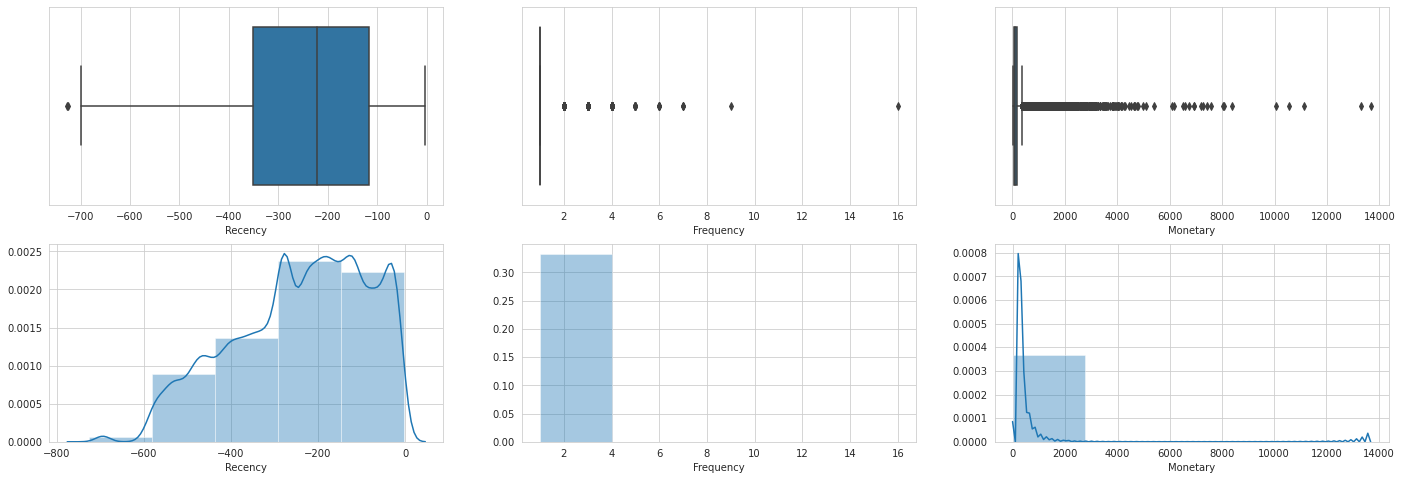

In [65]:
dfRFM = spark.sql('SELECT customer_unique_id, Recency, Frequency, Monetary FROM rfm0').toPandas().set_index('customer_unique_id')
fig, axes = plt.subplots(2,3,figsize=(24,8))
for idx, axe in enumerate(axes):
    for col, ax in zip(dfRFM.columns, axe):
        if idx==1:
            sns.distplot(dfRFM[col],ax=ax, bins = 5)
        else:
            sns.boxplot(dfRFM[col],ax=ax)
plt.show()

In [66]:
for col in dfRFM.columns:
    print(dfRFM[col].value_counts().iloc[:3])

-281    1133
-280     483
-278     388
Name: Recency, dtype: int64
1    92499
2     2672
3      192
Name: Frequency, dtype: int64
77.570000    238
35.000000    149
73.339996    144
Name: Monetary, dtype: int64


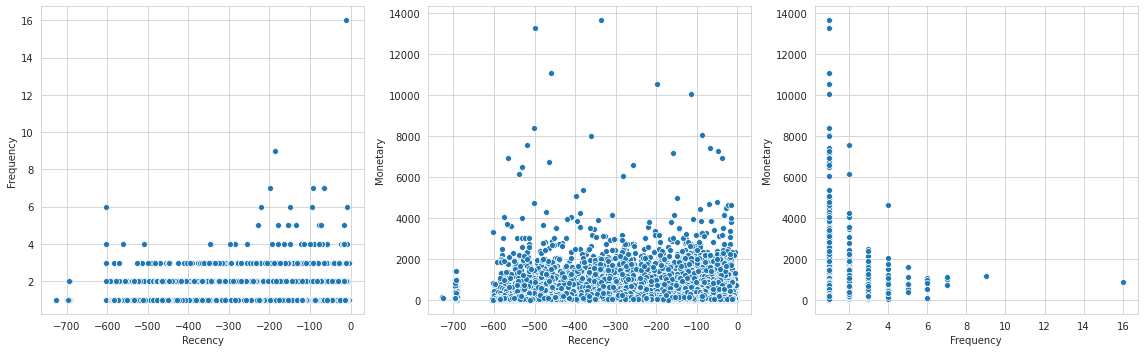

In [67]:
fig, axes = plt.subplots(1,3,figsize=(16,5))
for ax, x, y in zip(axes, [0,0,1],[1,2,2]):
    sns.scatterplot(dfRFM.iloc[:,x], dfRFM.iloc[:,y], ax = ax)
plt.tight_layout()
plt.show()

Based on the data distribution visualization above, `Frequency` looks very skewed to the value of 1 and `Monetary` is also skewed very bad to the left. Only because of these features, clustering using machine learning models looks unpromising due to very high probability of the model to be biasing towards `Frequency` and `Monetary` features. Nor will quantile cut and rank based cut will work well. Segmenting the data based on quantile will not represent the data well due to quantile cut dividing more than 90% of the `Frequency` with value = 1 to several segments which will not represent the data. On the other hand, segmenting based on rank will not work either because of the large range in `Monetary` feature causing the feature to stay extremely skewed and making customer segmentation harder. Thus, an `if then` rule will be used to segment the customers. The segmentation will follow the rules in the query below.

In [76]:
spark.sql(
    '''
    SELECT customer_unique_id, Recency, Frequency, Monetary,
    Monetary / Frequency AS avg_trx_value,
    CASE
        WHEN Recency BETWEEN -90 AND 0 THEN 5
        WHEN Recency BETWEEN -180 AND -91  THEN 4
        WHEN Recency BETWEEN -270 AND -181  THEN 3
        WHEN Recency BETWEEN -366 AND -271 THEN 2
        ELSE 1
        END R,
    CASE 
        WHEN Frequency = 1 THEN 1
        WHEN Frequency BETWEEN 2 AND 3 THEN 2
        WHEN Frequency BETWEEN 4 AND 5 THEN 3
        WHEN Frequency BETWEEN 6 AND 7 THEN 4
        ELSE 5
        END F,
    CASE 
        WHEN Monetary <= 100 THEN 1 
        WHEN Monetary BETWEEN 100.0000000000000001 AND 250 THEN 2 
        WHEN Monetary BETWEEN 250.0000000000000001 AND 500 THEN 3
        WHEN Monetary BETWEEN 500.0000000000000001 AND 1000 THEN 4
        ELSE 5
        END M
    FROM rfm0
    '''
).createOrReplaceTempView('rfm_ordinal')

spark.sql(
    '''
    SELECT 
    R, COUNT(Recency), MIN(Recency),MAX(Recency), Mean(Recency)
    FROM rfm_ordinal GROUP BY R ORDER BY R DESC
    '''
).show()

spark.sql(
    '''
    SELECT 
    F, COUNT(Frequency), MIN(Frequency),MAX(Frequency), Mean(Frequency)
    FROM rfm_ordinal GROUP BY F ORDER BY F DESC
    '''
).show()

spark.sql(
    '''
    SELECT 
    M, COUNT(Monetary), MIN(Monetary),MAX(Monetary), Mean(Monetary)  
    FROM rfm_ordinal GROUP BY M ORDER BY M DESC
    '''
).show()

+---+--------------+------------+------------+-------------------+
|  R|count(Recency)|min(Recency)|max(Recency)|      mean(Recency)|
+---+--------------+------------+------------+-------------------+
|  5|         18343|         -90|          -3| -46.42403096549092|
|  4|         19870|        -180|         -91|-137.05239053850025|
|  3|         18792|        -270|        -181| -222.7136547467007|
|  2|         16761|        -366|        -271| -310.2916293777221|
|  1|         21645|        -727|        -367|-465.57209517209515|
+---+--------------+------------+------------+-------------------+

+---+----------------+--------------+--------------+------------------+
|  F|count(Frequency)|min(Frequency)|max(Frequency)|   mean(Frequency)|
+---+----------------+--------------+--------------+------------------+
|  5|               2|             9|            16|              12.5|
|  4|               8|             6|             7|             6.375|
|  3|              38|             4

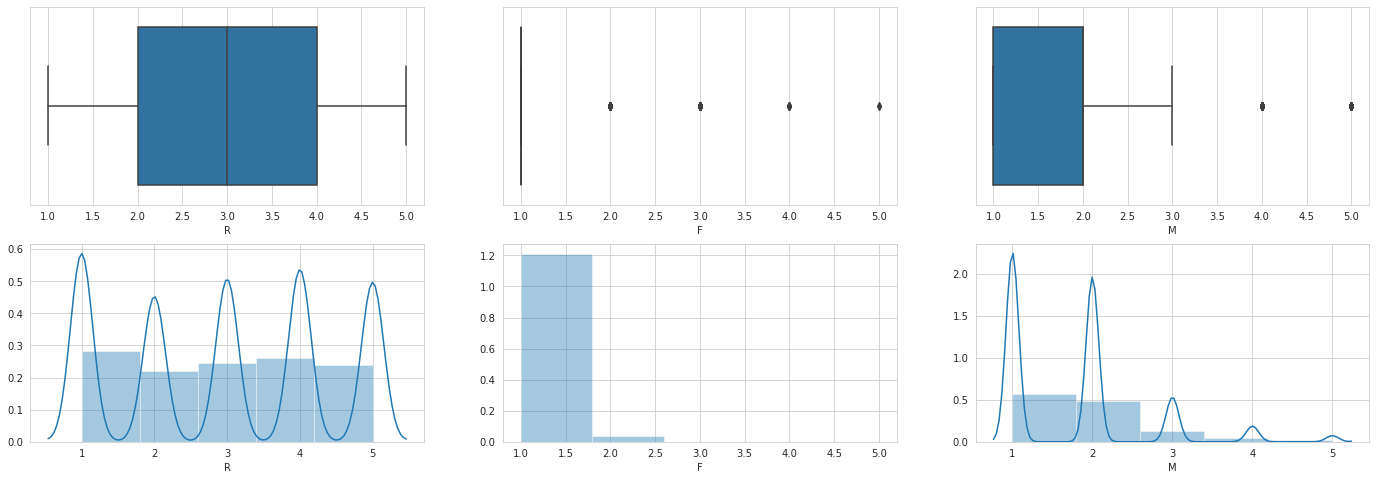

In [77]:
dfRFM_ = spark.sql('SELECT * FROM rfm_ordinal').toPandas().set_index('customer_unique_id')

fig, axes = plt.subplots(2,3,figsize=(24,8))
for idx, axe in enumerate(axes):
    for col, ax in zip(['R','F','M'], axe):
        if idx==1:
            sns.distplot(dfRFM_[col],ax=ax, bins = 5)
        else:
            sns.boxplot(dfRFM_[col],ax=ax)
plt.show()

As expected, `Frequency` feature becomes a troublemaker in the segmentation. However, `Monetary` feature is less skewed after the segmentation.

## RFM Segment Analysis

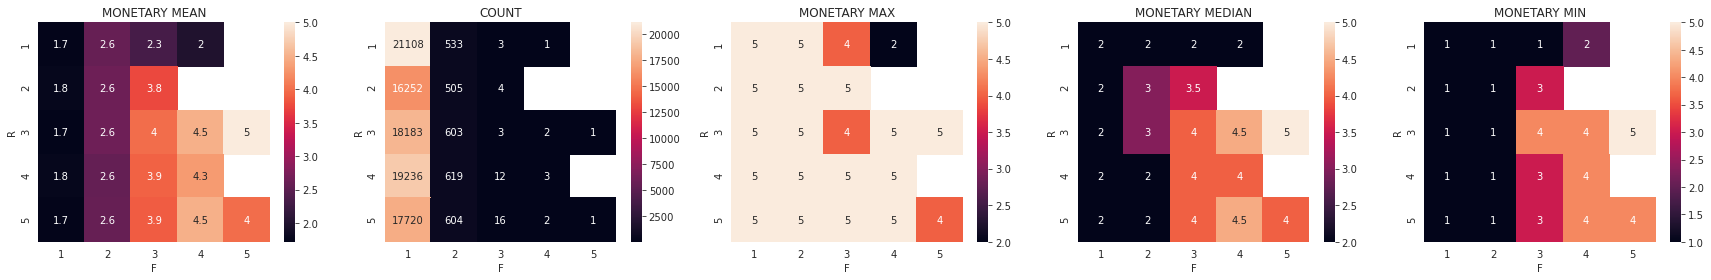

In [78]:
fig = plt.figure(figsize = (24,4))

gb_monetary = dfRFM_.groupby(['R','F'])['M'].agg(['count','mean','max','min','median']).unstack()

ax = fig.add_subplot(151)
ax.set_title('MONETARY MEAN')
sns.heatmap(gb_monetary['mean'],annot=True,ax=ax)

ax = fig.add_subplot(152)
ax.set_title('COUNT')
sns.heatmap(gb_monetary['count'],annot=True,ax=ax,fmt='g')

ax = fig.add_subplot(153)
ax.set_title('MONETARY MAX')
sns.heatmap(gb_monetary['max'],annot=True,ax=ax)

ax = fig.add_subplot(154)
ax.set_title('MONETARY MEDIAN')
sns.heatmap(gb_monetary['median'],annot=True,ax=ax)

ax = fig.add_subplot(155)
ax.set_title('MONETARY MIN')
sns.heatmap(gb_monetary['min'],annot=True,ax=ax)

plt.tight_layout()
plt.show()

After Recency, Frequency, and Monetary Segmentation, it is not surprising to see the frequent buyers become high spenders as well.

## Customer Segmentation

Customer segmentation will be made based on R and F segment by following the table below. M segment will determine whether a customer is low spender or high spender. A customer is high when his/her M segment score is higher than 2.

| R\F | 1                                         | 2                                         | 3                                                     | 4                                                     | 5                                                     |
|-----|-------------------------------------------|-------------------------------------------|-------------------------------------------------------|-------------------------------------------------------|-------------------------------------------------------|
| 1   | Churned Low Spender/ Churned High Spender | Churned Low Spender/ Churned High Spender | Churned Frequent Low Spender/ Churned Frequent High Spender | Churned Frequent Low Spender/ Churned Frequent High Spender | Churned Frequent Low Spender/ Churned Frequent High Spender |
| 2   | Churned Low Spender/ Churned High Spender | Churned Low Spender/ Churned High Spender | Churned Frequent Low Spender/ Churned Frequent High Spender | Churned Frequent Low Spender/ Churned Frequent High Spender | Churned Frequent Low Spender/ Churned Frequent High Spender |
| 3   | Churned Low Spender/ Churned High Spender | Churned Low Spender/ Churned High Spender | Frequent Low Spender/ Frequent High Spender                 | Frequent Low Spender/ Frequent High Spender                 | Frequent Low Spender/ Frequent High Spender                 |
| 4   | New Low Spender/ New High Spender         | New Low Spender/ New High Spender         | New Frequent Low Spender/ New Frequent High Spender                 | New Frequent Low Spender/ Best Customer                 | New Frequent Low Spender/ Best Customer                      |
| 5   | New Low Spender/ New High Spender         | New Low Spender/ New High Spender         | New Frequent Low Spender/ New Frequent High Spender                 | New Frequent Low Spender/ Best Customer                      | New Frequent Low Spender/ Best Customer                      |

In [79]:
dfRFM_ = spark.sql(
    '''
    SELECT customer_unique_id, Recency, Frequency, Monetary, avg_trx_value, R, F, M, CONCAT(R,F,M) AS rfm_segment, (R+F+M) AS rfm_score,
    CASE
        WHEN M < 3 THEN CONCAT(rf_segmentation, ' Low Spender')
        WHEN M > 3 AND R > 3 AND F > 3 THEN 'Best Customer'
        ELSE CONCAT(rf_segmentation, ' High Spender')
        END rfm_segmentation
    FROM
        (SELECT *, 
        CASE
            WHEN R > 3 THEN CONCAT('New ', f_segmentation)
            WHEN R = 3 AND F > 2 THEN f_segmentation
            ELSE CONCAT('Churned ', f_segmentation)
            END rf_segmentation
        FROM
            (SELECT *,
            CASE 
                WHEN F > 2 THEN 'Frequent'
                ELSE ''
                END f_segmentation
            FROM rfm_ordinal)
        )
    ORDER BY rfm_segmentation, rfm_score DESC, Recency
    '''
).createOrReplaceTempView('rfm_seg')

dfRFM_0 = spark.sql('SELECT * FROM rfm_seg').toPandas()
dfRFM_0.head(10)

,customer_unique_id,Recency,Frequency,Monetary,avg_trx_value,R,F,M,rfm_segment,rfm_score,rfm_segmentation
0,8d50f5eadf50201ccdcedfb9e2ac8455,-12,16,902.040009,56.377501,5,5,4,554,14,Best Customer
1,dc813062e0fc23409cd255f7f53c7074,-9,6,1094.629997,182.438333,5,4,5,545,14,Best Customer
2,ca77025e7201e3b30c44b472ff346268,-92,7,1122.719986,160.388569,4,4,5,445,13,Best Customer
3,6469f99c1f9dfae7733b25662e7f1782,-65,7,758.830006,108.404287,5,4,4,544,13,Best Customer
4,f0e310a6839dce9de1638e0fe5ab282a,-149,6,540.689991,90.114998,4,4,4,444,12,Best Customer
5,63cfc61cee11cbe306bff5857d00bfe4,-96,6,826.320015,137.720002,4,4,4,444,12,Best Customer
6,7ea3dc64a652d699ace3048e904c561b,-269,2,1003.620026,501.810013,3,2,5,325,10,Churned High Spender
7,d5419994a02a55d4b7cd00e77fabdbae,-269,2,2255.190018,1127.595009,3,2,5,325,10,Churned High Spender
8,8bb910cd8c3b29e4acf2e94e3aaffbbf,-267,2,1131.079971,565.539986,3,2,5,325,10,Churned High Spender
9,12ab9334b1240d6d037f2b0102a49571,-262,2,1297.469955,648.734978,3,2,5,325,10,Churned High Spender


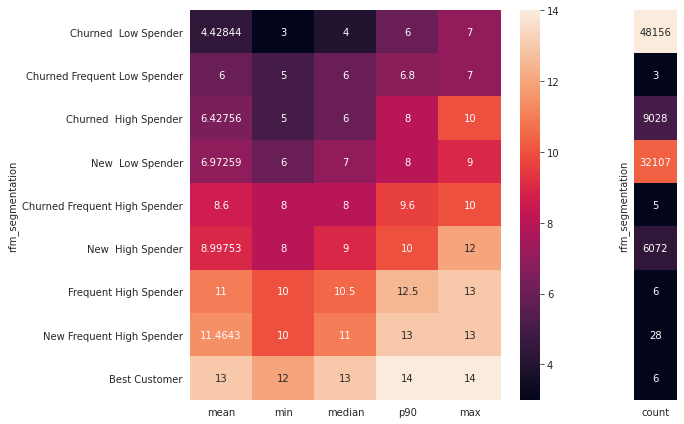

In [181]:
def p90(x): return np.percentile(x, 90)
gb = dfRFM_0.groupby('rfm_segmentation')['rfm_score'].agg(['mean','min','median', p90,'max','count']).sort_values('mean')
fig,ax = plt.subplots(1,2,figsize=(12,6))
sns.heatmap(gb.iloc[:,:-1],fmt='g',annot=True,ax=ax[0])
sns.heatmap(gb[['count']],fmt='g',annot=True,ax=ax[1],cbar=False, yticklabels=False, square='equal')
plt.tight_layout()
plt.show()

In [142]:
(dfRFM_0['R'] > 3).mean()

0.40050937522927127

In [141]:
(dfRFM_0['F'] > 2).mean()

0.0005030866461938351

In [143]:
(dfRFM_0['M'] > 3).mean()

0.05155590026307239

There seems to be no, frequent low spender and nearly zero frequent low spenders who churns. This means that the customers who buy often have spent more than 500 pesos in OLIST. Lets take a deeper analysis on the feature engineered data

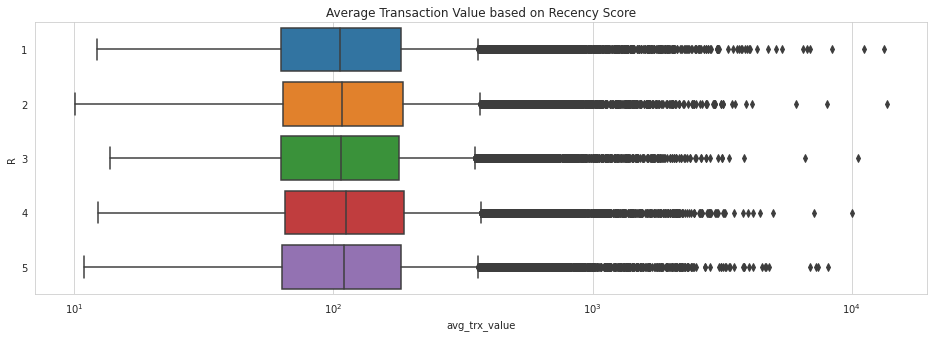

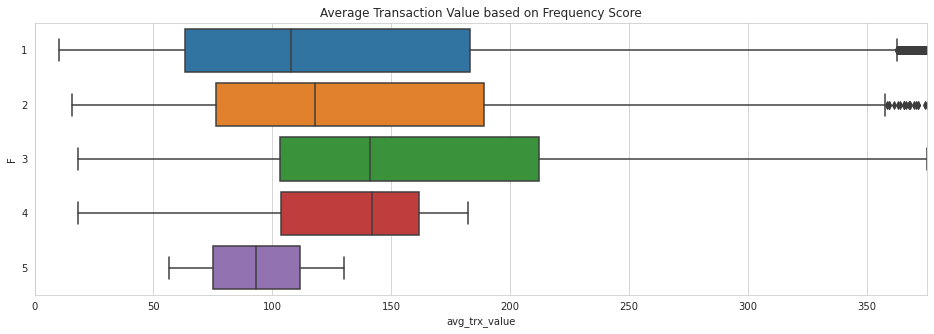

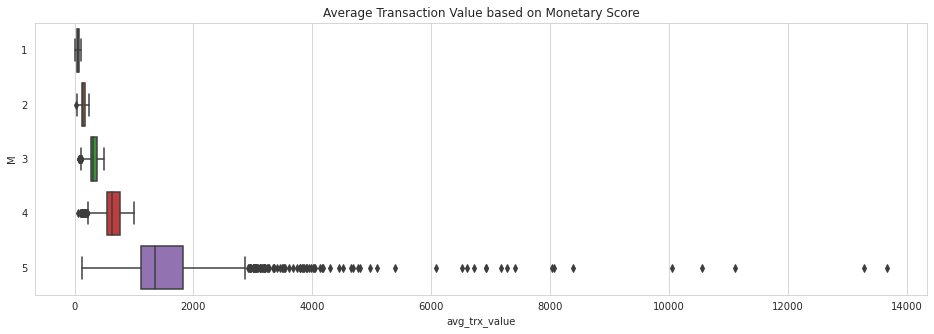

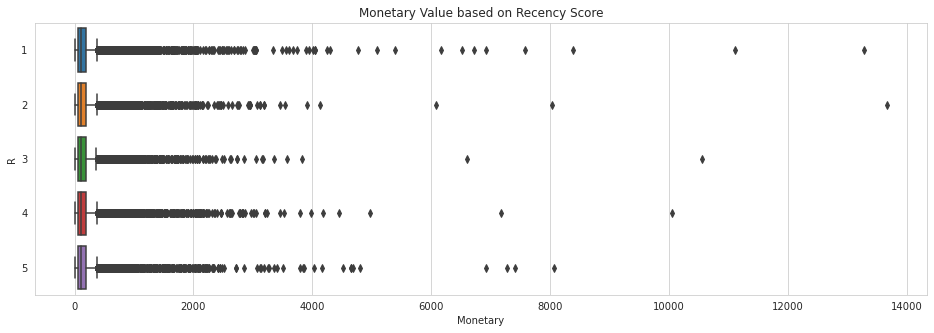

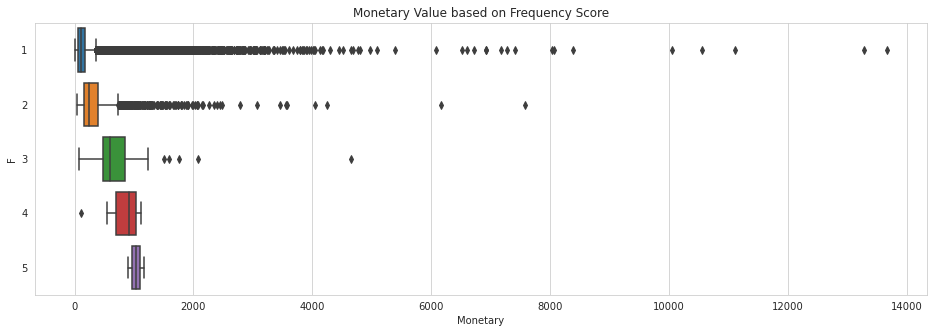

In [283]:
def get_outlier_limits(x):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

def set_xlim(df, x, y):
    lower_limit = df.groupby(y)[x].apply(lambda x: get_outlier_limits(x)[0]).min()
    if x != 'Recency':
        lower_limit = 0 if lower_limit < 0 else lower_limit
    upper_limit = df.groupby(y)[x].apply(lambda x: get_outlier_limits(x)[1]).max()
    if x == 'Recency':
        upper_limit = 0 if upper_limit > 0 else upper_limit
    return lower_limit, upper_limit

def draw_boxplot(df, x, y, title = None, x_logscale = False, drop_outliers = True):
    plt.figure(figsize = (16, 5))
    sns.boxplot(x, y, data = df, orient = 'h')
    if title:
        plt.title(title)
    if drop_outliers:
        plt.xlim(set_xlim(dfRFM_0, x, y))
    if x_logscale:
        plt.xscale('log')
    plt.show()
    
draw_boxplot(dfRFM_0, 'avg_trx_value', 'R', 'Average Transaction Value based on Recency Score', True, False)
draw_boxplot(dfRFM_0, 'avg_trx_value', 'F', 'Average Transaction Value based on Frequency Score', False, True)
draw_boxplot(dfRFM_0, 'avg_trx_value', 'M', 'Average Transaction Value based on Monetary Score', False, False)
draw_boxplot(dfRFM_0, 'Monetary', 'R', 'Monetary Value based on Recency Score', False, False)
draw_boxplot(dfRFM_0, 'Monetary', 'F', 'Monetary Value based on Frequency Score', False, False)

It is quite interesting to see that customers with Frequency score larger than 3 has a lower 75th percentile average transaction value compared to customers with Frequency score smaller than 4. The next question to ask is, whether there are any particular products or sellers preferred by these customers? If there are some, using those product or sellers as part of marketing campaign may engage the other customers to stay loyal to OLIST

Note:
*There are only 10 customers who has frequency score more than 3*

In [200]:
spark.sql(
    '''
    SELECT *
    FROM merged3
    JOIN
    (SELECT customer_unique_id, Frequency, rfm_score
    FROM rfm_seg
    WHERE F > 3) USING(customer_unique_id)
    ORDER BY Frequency DESC, rfm_score DESC,customer_unique_id
    '''
).toPandas()

,customer_unique_id,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,review_score,review_comment_present,Frequency,rfm_score
0,8d50f5eadf50201ccdcedfb9e2ac8455,a1a6eadae352582010f449d8527b55f3,1.0,426f910ccd39ae5e7d55013c466fe343,0691148aee60ca47977c187804f935ae,2018-08-23,72.0,23.0,sports_leisure,57.0,340.0,1.0,350.0,43.0,30.0,32.0,3414a9c813e3ca02504b8be8b2deb27f,delivered,2018-08-18,sao paulo,SP,1,credit_card,2,96.400002,5,0,16,14
1,8d50f5eadf50201ccdcedfb9e2ac8455,b850a16d8faf65a74c51287ef34379ce,1.0,5bccc8fe44471df6c7b7e08176837d2f,1da3aeb70d7989d1e6d9b0e887f97c23,2017-11-28,13.0,7.0,sports_leisure,44.0,87.0,3.0,150.0,20.0,20.0,20.0,1bd3585471932167ab72a84955ebefea,delivered,2017-11-22,sao paulo,SP,1,credit_card,1,21.770000,5,0,16,14
2,8d50f5eadf50201ccdcedfb9e2ac8455,5837a2c844decae8a778657425f6d664,NaN,None,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31dd055624c66f291578297a551a6cdf,unavailable,2017-07-17,sao paulo,SP,1,credit_card,1,25.590000,1,0,16,14
3,8d50f5eadf50201ccdcedfb9e2ac8455,23427a6bd9f8fd1b51f1b1e5cc186ab8,1.0,5cb96c51c55f57503465e4d2558dc053,db4350fd57ae30082dec7acbaacc17f9,2018-05-24,45.0,7.0,sports_leisure,53.0,282.0,1.0,300.0,35.0,6.0,11.0,a8fabc805e9a10a3c93ae5bff642b86b,delivered,2018-05-21,sao paulo,SP,1,credit_card,1,53.380001,5,0,16,14
4,8d50f5eadf50201ccdcedfb9e2ac8455,d3582fd5ccccd9cb229a63dfb417c86f,1.0,df473738565b52f77b4e22b328b41576,01266d4c46afa519678d16a8b683d325,2018-08-22,23.0,15.0,costruction_tools_tools,42.0,369.0,1.0,400.0,16.0,2.0,11.0,a682769c4bc10fc6ef2101337a6c83c9,delivered,2018-08-20,sao paulo,SP,1,credit_card,1,38.660000,5,0,16,14
5,8d50f5eadf50201ccdcedfb9e2ac8455,112eb6f37f1b9dabbced368fbbc6c9ef,1.0,41f6cb7c3b1200749326e50106f32d58,db4350fd57ae30082dec7acbaacc17f9,2018-07-30,99.0,8.0,sports_leisure,59.0,405.0,2.0,330.0,45.0,6.0,18.0,65f9db9dd07a4e79b625effa4c868fcb,delivered,2018-07-23,sao paulo,SP,1,credit_card,1,107.849998,5,0,16,14
6,8d50f5eadf50201ccdcedfb9e2ac8455,6bdf325f0966e3056651285c0aed5aad,1.0,d6354128c28cc56532ba7393d9373083,412a4720f3e9431b4afa1476a1acddbe,2018-05-24,51.0,11.0,sports_leisure,38.0,203.0,1.0,1000.0,16.0,6.0,12.0,6289b75219d757a56c0cce8d9e427900,delivered,2018-05-22,sao paulo,SP,1,credit_card,1,62.950001,5,0,16,14
7,8d50f5eadf50201ccdcedfb9e2ac8455,838f8e96cf584a1d8d22eaf7143c7772,1.0,fe7e33eaa09b5a4a3d3aa477280db875,1da3aeb70d7989d1e6d9b0e887f97c23,2018-07-08,22.0,7.0,fashion_bags_accessories,19.0,270.0,1.0,150.0,20.0,10.0,20.0,f5188d99e9281e214a4a7d1b139a8229,delivered,2018-07-04,sao paulo,SP,1,credit_card,1,30.410000,5,0,16,14
8,8d50f5eadf50201ccdcedfb9e2ac8455,369634708db140c5d2c4e365882c443a,1.0,d83509907a19c72e1e4cdde78b8177ec,94e93ce877be27a515118dbfd2c2be41,2017-06-22,39.0,11.0,sports_leisure,25.0,303.0,2.0,200.0,25.0,5.0,12.0,b2b13de0770e06de50080fea77c459e6,delivered,2017-06-18,sao paulo,SP,1,credit_card,2,51.750000,5,0,16,14
9,8d50f5eadf50201ccdcedfb9e2ac8455,5d848f3d93a493c1c8955e018240e7ca,1.0,4e1d2ef2974c85d82582edfe594a4f57,1da3aeb70d7989d1e6d9b0e887f97c23,2017-05-21,14.0,7.0,sports_leisure,43.0,191.0,4.0,300.0,25.0,10.0,20.0,0e4fdc084a6b9329ed55d62dcd653ccf,shipped,2017-05-15,sao paulo,SP,1,credit_card,1,22.770000,5,0,16,14


In [205]:
spark.sql(
    '''
    SELECT customer_unique_id, 
        product_id, 
        COUNT(1) AS product_buy_frequency, 
        MAX(Frequency) AS Frequency, 
        AVG(review_score) AS avg_review_score
    FROM merged3
    JOIN
    (SELECT customer_unique_id, Frequency, rfm_score
    FROM rfm_seg
    WHERE F > 3) USING(customer_unique_id)
    GROUP BY customer_unique_id, product_id
    ORDER BY 4 DESC, 1, 3 DESC
    '''
).toPandas()

,customer_unique_id,product_id,product_buy_frequency,Frequency,avg_review_score
0,8d50f5eadf50201ccdcedfb9e2ac8455,94cc774056d3f2b0dc693486a589025e,2,16,5.0
1,8d50f5eadf50201ccdcedfb9e2ac8455,426f910ccd39ae5e7d55013c466fe343,1,16,5.0
2,8d50f5eadf50201ccdcedfb9e2ac8455,5bccc8fe44471df6c7b7e08176837d2f,1,16,5.0
3,8d50f5eadf50201ccdcedfb9e2ac8455,5cb96c51c55f57503465e4d2558dc053,1,16,5.0
4,8d50f5eadf50201ccdcedfb9e2ac8455,df473738565b52f77b4e22b328b41576,1,16,5.0
5,8d50f5eadf50201ccdcedfb9e2ac8455,41f6cb7c3b1200749326e50106f32d58,1,16,5.0
6,8d50f5eadf50201ccdcedfb9e2ac8455,d6354128c28cc56532ba7393d9373083,1,16,5.0
7,8d50f5eadf50201ccdcedfb9e2ac8455,fe7e33eaa09b5a4a3d3aa477280db875,1,16,5.0
8,8d50f5eadf50201ccdcedfb9e2ac8455,d83509907a19c72e1e4cdde78b8177ec,1,16,5.0
9,8d50f5eadf50201ccdcedfb9e2ac8455,4e1d2ef2974c85d82582edfe594a4f57,1,16,5.0


In [216]:
spark.sql(
    '''
    SELECT product_id, 
        COUNT(1) AS product_buy_frequency, 
        COUNT(DISTINCT(customer_unique_id)) AS number_of_unique_buyers,
        COUNT(1) / COUNT(DISTINCT(customer_unique_id)) AS number_of_purchase_per_unique_customer,
        AVG(review_score) AS avg_review_score
    FROM merged3
    JOIN
    (SELECT customer_unique_id, Frequency, rfm_score
    FROM rfm_seg
    WHERE F > 3) USING(customer_unique_id)
    GROUP BY product_id
    ORDER BY 2 DESC, 3 DESC
    '''
).toPandas()

,product_id,product_buy_frequency,number_of_unique_buyers,number_of_purchase_per_unique_customer,avg_review_score
0,c211ff3068fcd2f8898192976d8b3a32,5,1,5.0,5.0
1,db12039c7ff4e850d48e0312fa9b3473,4,1,4.0,5.0
2,d84339772d824505b7f19e647f373ec3,4,1,4.0,5.0
3,423b46d7ff817b1cd19ab195c7b76546,3,1,3.0,3.0
4,f7e5d0186f539b61586d7ddd247d2996,3,1,3.0,3.0
5,d0be993a2140a8cfe0a106b6c2d974b6,3,1,3.0,5.0
6,b623b7cb05ee3248fbe4a6ecbeed79a4,2,1,2.0,5.0
7,7b49e585ac8c80b14c9b2815d4db465f,2,1,2.0,2.0
8,4cda9d93b0a846dfdca597f1b1d19c08,2,1,2.0,5.0
9,f5d8f4fbc70ca2a0038b9a0010ed5cb0,2,1,2.0,5.0


In [212]:
spark.sql(
    '''
    SELECT customer_unique_id, 
        product_category_name, 
        COUNT(1) AS product_buy_frequency, 
        AVG(Frequency) AS Frequency, 
        AVG(review_score) AS avg_review_score
    FROM merged3
    JOIN
    (SELECT customer_unique_id, Frequency, rfm_score
    FROM rfm_seg
    WHERE F > 3) USING(customer_unique_id)
    GROUP BY customer_unique_id, product_category_name
    ORDER BY 4 DESC, 1, 3 DESC
    '''
).toPandas()

,customer_unique_id,product_category_name,product_buy_frequency,Frequency,avg_review_score
0,8d50f5eadf50201ccdcedfb9e2ac8455,sports_leisure,11,16.0,5.000000
1,8d50f5eadf50201ccdcedfb9e2ac8455,fashion_bags_accessories,3,16.0,5.000000
2,8d50f5eadf50201ccdcedfb9e2ac8455,None,2,16.0,3.000000
3,8d50f5eadf50201ccdcedfb9e2ac8455,costruction_tools_tools,1,16.0,5.000000
4,3e43e6105506432c953e165fb2acf44c,bed_bath_table,8,9.0,2.250000
5,3e43e6105506432c953e165fb2acf44c,furniture_decor,3,9.0,3.333333
6,3e43e6105506432c953e165fb2acf44c,computers_accessories,1,9.0,3.000000
7,3e43e6105506432c953e165fb2acf44c,housewares,1,9.0,3.000000
8,3e43e6105506432c953e165fb2acf44c,home_construction,1,9.0,3.000000
9,1b6c7548a2a1f9037c1fd3ddfed95f33,furniture_decor,4,7.0,5.000000


In [215]:
spark.sql(
    '''
    SELECT product_category_name, 
        COUNT(1) AS product_buy_frequency, 
        COUNT(DISTINCT(customer_unique_id)) AS number_of_unique_buyers,
        COUNT(1) / COUNT(DISTINCT(customer_unique_id)) AS number_of_purchase_per_unique_customer,
        AVG(review_score) AS avg_review_score
    FROM merged3
    JOIN
    (SELECT customer_unique_id, Frequency, rfm_score
    FROM rfm_seg
    WHERE F > 3) USING(customer_unique_id)
    GROUP BY 1
    ORDER BY 2 DESC, 3 DESC
    '''
).toPandas()

,product_category_name,product_buy_frequency,number_of_unique_buyers,number_of_purchase_per_unique_customer,avg_review_score
0,bed_bath_table,23,6,3.833333,3.913043
1,furniture_decor,14,4,3.500000,4.214286
2,cool_stuff,11,3,3.666667,5.000000
3,sports_leisure,11,1,11.000000,5.000000
4,housewares,7,4,1.750000,4.714286
5,None,5,3,1.666667,4.200000
6,fashion_bags_accessories,5,2,2.500000,5.000000
7,toys,4,1,4.000000,4.750000
8,health_beauty,3,2,1.500000,5.000000
9,watches_gifts,3,1,3.000000,3.000000


In [207]:
spark.sql(
    '''
    SELECT customer_unique_id, 
        seller_id, 
        COUNT(1) AS product_buy_from_seller_frequency, 
        MAX(Frequency) AS Frequency, 
        AVG(review_score) AS avg_review_score
    FROM merged3
    JOIN
    (SELECT customer_unique_id, Frequency, rfm_score
    FROM rfm_seg
    WHERE F > 3) USING(customer_unique_id)
    GROUP BY customer_unique_id, seller_id
    ORDER BY 4 DESC, 1, 3 DESC
    '''
).toPandas()

,customer_unique_id,seller_id,product_buy_from_seller_frequency,Frequency,avg_review_score
0,8d50f5eadf50201ccdcedfb9e2ac8455,1da3aeb70d7989d1e6d9b0e887f97c23,7,16,5.0
1,8d50f5eadf50201ccdcedfb9e2ac8455,db4350fd57ae30082dec7acbaacc17f9,2,16,5.0
2,8d50f5eadf50201ccdcedfb9e2ac8455,94e93ce877be27a515118dbfd2c2be41,2,16,5.0
3,8d50f5eadf50201ccdcedfb9e2ac8455,0691148aee60ca47977c187804f935ae,1,16,5.0
4,8d50f5eadf50201ccdcedfb9e2ac8455,01266d4c46afa519678d16a8b683d325,1,16,5.0
5,8d50f5eadf50201ccdcedfb9e2ac8455,412a4720f3e9431b4afa1476a1acddbe,1,16,5.0
6,8d50f5eadf50201ccdcedfb9e2ac8455,fdaaf5bfda82b7b80535610c831b8d09,1,16,5.0
7,8d50f5eadf50201ccdcedfb9e2ac8455,a3a38f4affed601eb87a97788c949667,1,16,5.0
8,8d50f5eadf50201ccdcedfb9e2ac8455,None,1,16,1.0
9,3e43e6105506432c953e165fb2acf44c,4200ddf1967c5e41e48db62bc6d4b5ac,4,9,2.0


In [217]:
spark.sql(
    '''
    SELECT seller_id, 
        COUNT(1) AS product_buy_from_seller_frequency, 
        COUNT(DISTINCT(customer_unique_id)) AS number_of_unique_buyers,
        COUNT(1) / COUNT(DISTINCT(customer_unique_id)) AS number_of_purchase_per_unique_customer,
        AVG(review_score) AS avg_review_score
    FROM merged3
    JOIN
    (SELECT customer_unique_id, Frequency, rfm_score
    FROM rfm_seg
    WHERE F > 3) USING(customer_unique_id)
    GROUP BY 1
    ORDER BY 2 DESC, 3 DESC
    '''
).toPandas()

,seller_id,product_buy_from_seller_frequency,number_of_unique_buyers,number_of_purchase_per_unique_customer,avg_review_score
0,da8622b14eb17ae2831f4ac5b9dab84a,7,2,3.500000,5.0
1,1da3aeb70d7989d1e6d9b0e887f97c23,7,1,7.000000,5.0
2,48efc9d94a9834137efd9ea76b065a38,6,1,6.000000,5.0
3,53e4c6e0f4312d4d2107a8c9cddf45cd,5,3,1.666667,5.0
4,4200ddf1967c5e41e48db62bc6d4b5ac,4,1,4.000000,2.0
5,46dc3b2cc0980fb8ec44634e21d2718e,4,1,4.000000,5.0
6,b2479f944e1b90cf8a5de1bbfde284d6,4,1,4.000000,5.0
7,244c2f1bff6afe1f2eaf9bfe9b2aed38,3,1,3.000000,5.0
8,6560211a19b47992c3666cc44a7e94c0,3,1,3.000000,3.0
9,48e5ee06fb2dc74df1c711a9b6dfac2a,3,1,3.000000,5.0


There are no product or sellers that are favored by the customers who made more than 5 purchases (Frequency score 4 and 5).

In [153]:
dfRFM_0.groupby('rfm_segmentation').agg({'Recency':[pd.Series.count, np.mean, np.median, p90],
                            **{col:[np.mean, np.median, p90] for col in ['Frequency', 'Monetary', 'avg_trx_value', 'rfm_score']}}
                        ).T.style.bar(axis = 1).format('{:.4f}')

In [264]:
dfRFM_0['rfm_segmentation'].value_counts(normalize = True).to_frame()\
    .join(dfRFM_0['rfm_segmentation'].value_counts(), lsuffix='_')\
    .rename(columns = {'rfm_segmentation_':'Count (Normalized)', 'rfm_segmentation':'Count'})\
    .join((dfRFM_0.groupby('rfm_segmentation')['Monetary'].sum() / dfRFM_0['Monetary'].sum()).sort_values(ascending = False).to_frame()\
        .join(dfRFM_0.groupby('rfm_segmentation')['Monetary'].sum(), lsuffix = ' (Normalized)'))\
    .join(dfRFM_0.groupby('rfm_segmentation')['Monetary'].agg(['count', 'sum']).apply(lambda x: x[1] / x[0], axis = 1)\
        .to_frame().rename(columns = {0:'Monetary / Number_of_Customers'}))\
    .join(spark.sql(
        '''
        SELECT rfm_segmentation, review_score
        FROM merged3
        JOIN (SELECT * FROM rfm_seg) USING (customer_unique_id)
        '''
    ).toPandas()\
        .groupby('rfm_segmentation')\
        .agg({'review_score':['mean', 'median', p90]})\
        .droplevel(0, axis = 1)\
        .rename(columns = {name:f'review_score ({name})' for name in ['mean', 'median', 'p90']}))\
    .style.format('{:.4f}')

,Count (Normalized),Count,Monetary (Normalized),Monetary,Monetary / Number_of_Customers,review_score (mean),review_score (median),review_score (p90)
Churned Low Spender,0.5047,48156.0000,0.3011,5016058.0671,104.1627,4.0273,5.0000,5.0000
New Low Spender,0.3365,32107.0000,0.2052,3418562.7326,106.4741,4.1328,5.0000,5.0000
Churned High Spender,0.0946,9028.0000,0.2910,4847551.8898,536.9464,3.7684,5.0000,5.0000
New High Spender,0.0636,6072.0000,0.2003,3336554.5095,549.4984,3.8831,5.0000,5.0000
New Frequent High Spender,0.0003,28.0000,0.0016,25952.6201,926.8793,4.1967,5.0000,5.0000
Frequent High Spender,0.0001,6.0000,0.0003,5048.2300,841.3717,4.0000,5.0000,5.0000
Best Customer,0.0001,6.0000,0.0003,5245.2300,874.2050,4.6818,5.0000,5.0000
Churned Frequent High Spender,0.0001,5.0000,0.0002,3409.0400,681.8080,4.7200,5.0000,5.0000
Churned Frequent Low Spender,0.0000,3.0000,0.0000,316.0000,105.3333,4.7143,5.0000,5.0000


From the table above, low spenders to dominate more than 80% buyers in OLIST and they total spending are almost the same (around 105 pesos). If we follow the Pareto Principle and focus on number of customers and the monetary value they offer, only Churned Low Spenders and New Low Spenders should be prioritized. OLIST can send emails to engage with these buyers and push notifications more often.

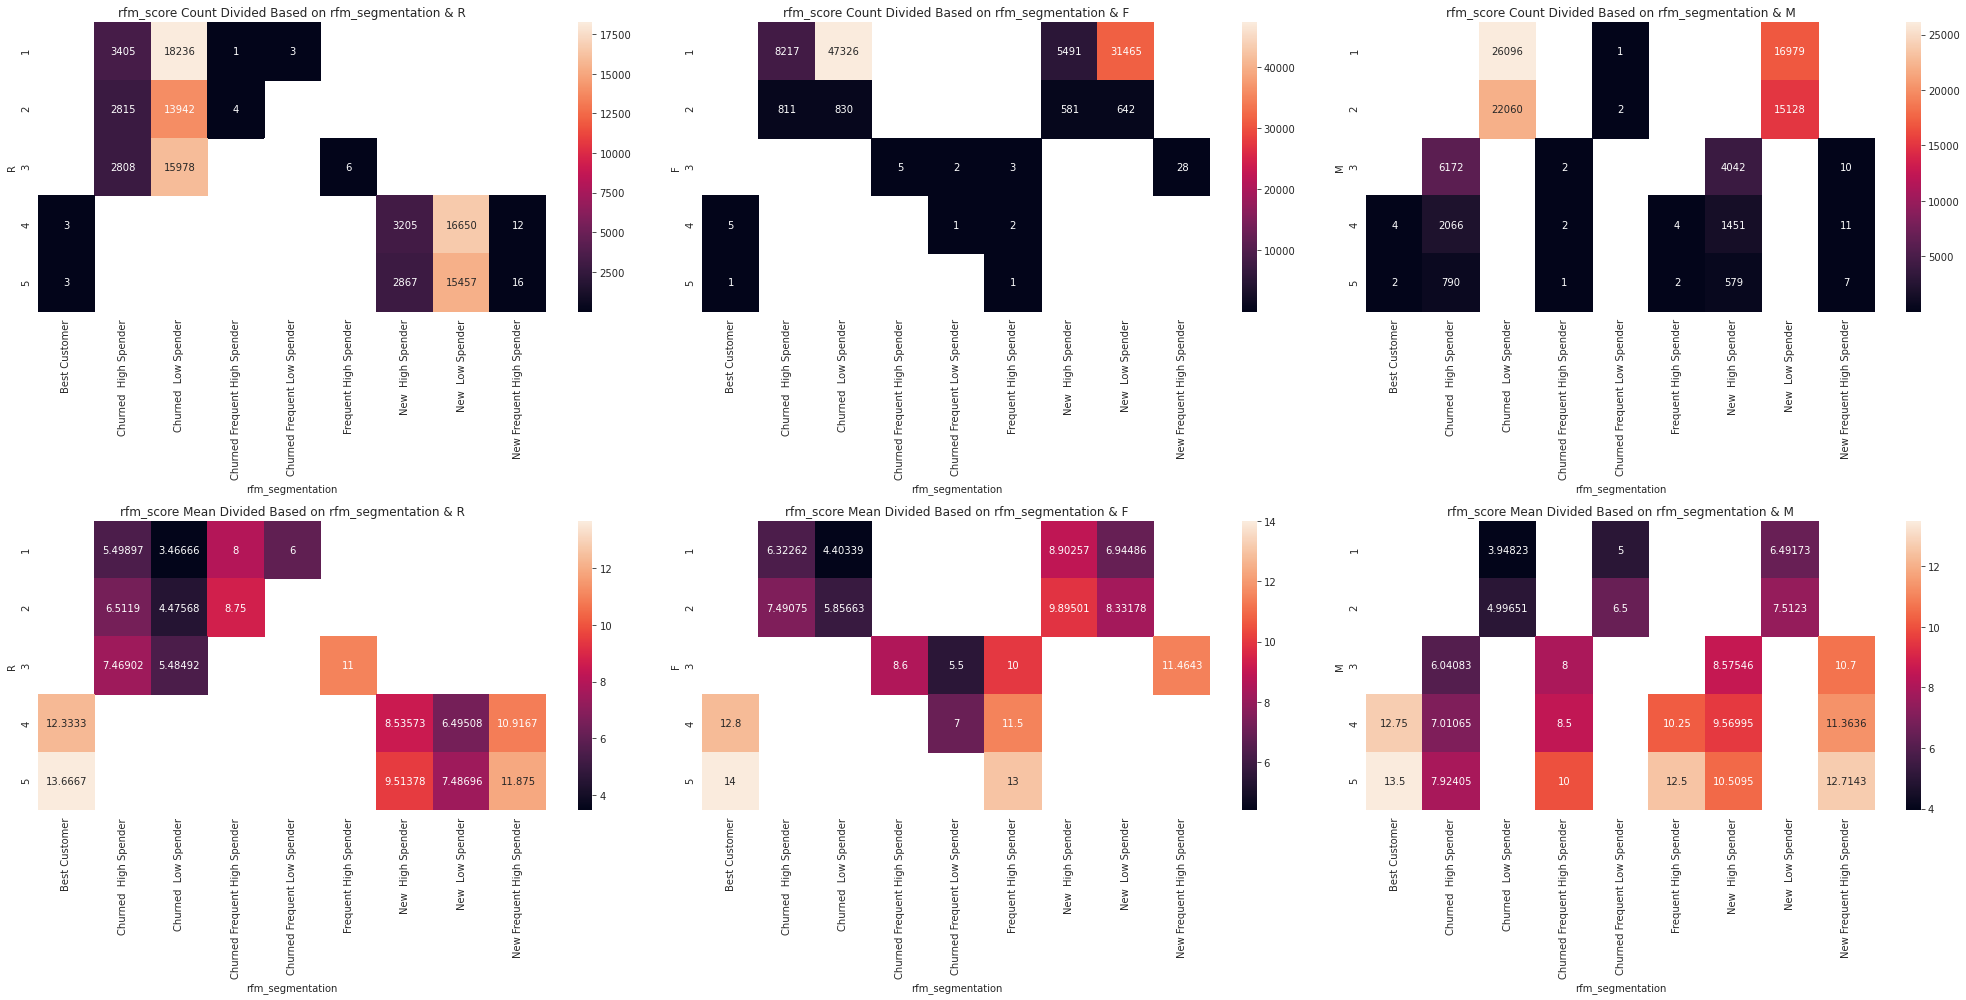

In [46]:
fig, axes = plt.subplots(2,3,figsize=(28,14))
for axs, agg in zip(axes, ['count','mean']):
    for ax, s in zip(axs, ['R','F','M']):
        gb = dfRFM_0.groupby([s,'rfm_segmentation'])['rfm_score'].agg(agg).unstack()
        sns.heatmap(gb,annot=True,fmt='g',ax=ax)
        ax.set_title(f'rfm_score {agg.capitalize()} Divided Based on rfm_segmentation & {s}')
plt.tight_layout()
plt.show()

Based on the customer segmentation, OLIST has 6 Best Customer with frequent high spending customer (including the churned and new ones) actually having potential to join the Best Customer segment if they are engaged to buy more frequently and consistently. However, if they're not engaged they can possibly churn.

 R entropy = 2.3167126799338393
 F entropy = 0.20114247915082623
 M entropy = 1.6578002630660584


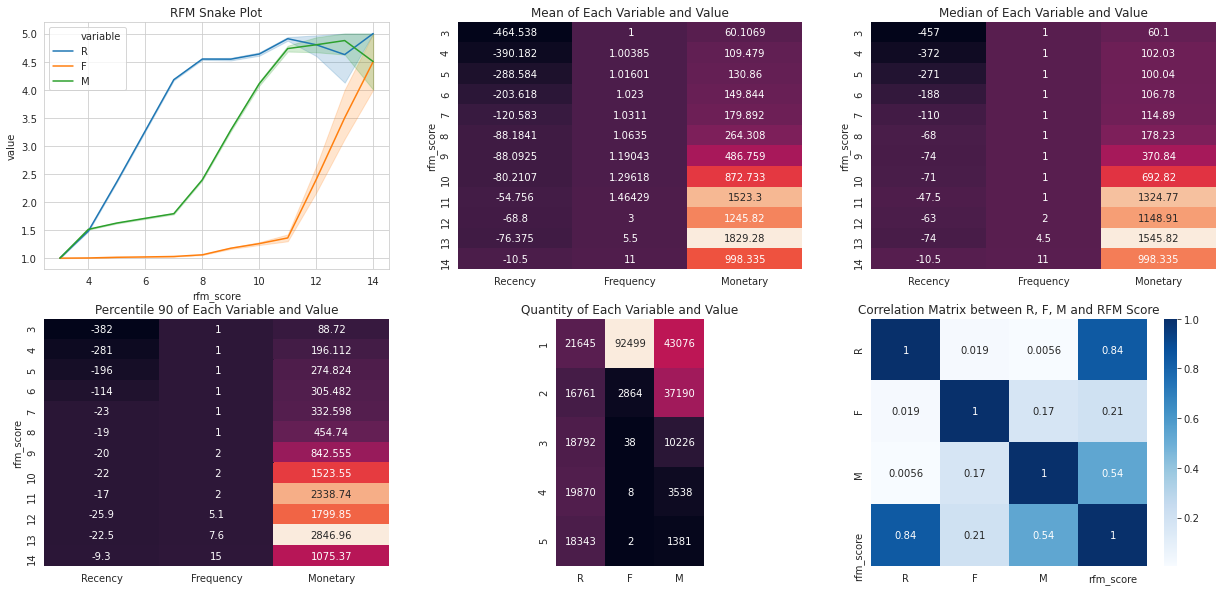

In [73]:
fig,ax = plt.subplots(2,3,figsize=(21,10))
sns.lineplot(x='rfm_score',y='value',hue='variable',data=pd.melt(frame=dfRFM_0,id_vars='rfm_score',value_vars=['R','F','M']), ax=ax[0][0], estimator='mean')
ax[0][0].set_title('RFM Snake Plot')
sns.heatmap(pd.DataFrame([dfRFM_0.groupby('rfm_score')[col].mean() for col in ['Recency','Frequency','Monetary']]).T,annot=True,fmt='2g',cbar=False,ax=ax[0][1])
ax[0][1].set_title('Mean of Each Variable and Value')
sns.heatmap(pd.DataFrame([dfRFM_0.groupby('rfm_score')[col].median() for col in ['Recency','Frequency','Monetary']]).T,annot=True,fmt='2g',cbar=False,ax=ax[0][2])
ax[0][2].set_title('Median of Each Variable and Value')
sns.heatmap(pd.DataFrame([dfRFM_0.groupby('rfm_score')[col].apply(lambda x: np.percentile(x, 90)) for col in ['Recency','Frequency','Monetary']]).T,annot=True,fmt='2g',cbar=False,ax=ax[1][0])
ax[1][0].set_title('Percentile 90 of Each Variable and Value')
sns.heatmap(pd.DataFrame([dfRFM_0[col].value_counts() for col in ['R','F','M']]).T,annot=True,fmt='g',cbar=False,square='equal',ax=ax[1][1])
ax[1][1].set_title('Quantity of Each Variable and Value')
sns.heatmap(dfRFM_0[['R','F','M','rfm_score']].corr(),annot=True,fmt='.2g', ax=ax[1][2], cmap = 'Blues')
ax[1][2].set_title('Correlation Matrix between R, F, M and RFM Score')

from scipy.stats import entropy
for col in ['R','F','M']:
    print(' {} entropy = {}'.format(col, entropy(dfRFM_0[col].value_counts(normalize=True), base=2)))

In the correlation matrix above, we can see that the most influential factor for the customer segmentation is Recency followed by Monetary. Frequency is less impactful towards towards customer segmenation. 

However, the RFM Snake Plot shows a different result where Frequency is the most influential factor. This is shown by the drastic increase of average Frequency score for customers with RFM score larger than 11. Another point shown by the snake plot is the average Monetary value starts to increase then the average Recency score is larger than 4.

Another interesting point is OLIST's customer with high rfm score sum are recent customers who purchases frequently. This is indicated by the Recency and Frequency having almost zero correlation with each lines mirroring each other in the snake plot. To support this argument, we can take a look at the 90th percentile of Frequency and Recency which increases quite drastic on the rfm score 7 for recency and rfm score 12 for frequency.

# Conclusion

1. 80% of the customers in OLIST are low spenders with total spending less than 250 pesos
2. Focusing on engaging these customers to spend more often will eventually lead them to be OLIST's best customer
3. The ideal spending per purchase for these customers marketing campaign would be around 80 to 120 pesos.
4. There are still no particular product which engages the best customers better.

# What's Next?
Now that we know the lifetime segmentation of each customer, the are other question that may need answers. I will not try to answer the questions in this notebook. But I will leave it here in case I or someone else wants to continue exploring the result of this analysis.

This question can be broken down into more questions such as:

- Why did the customers churn/stay?
- What product is bought the most in each customer segment?
- Where do the customers of each segment live?
- etc.

In [265]:
spark.sql(
    '''
    SELECT * FROM
        (SELECT merged3.*, rfm_seg.rfm_score, rfm_seg.rfm_segmentation 
        FROM merged3 FULL JOIN rfm_seg
        ON merged3.customer_unique_id = rfm_seg.customer_unique_id)
    WHERE ISNULL(rfm_segmentation) = false
    ORDER BY order_purchase_timestamp
    '''
).createOrReplaceTempView('merged4')

dfMerged_ = spark.sql('SELECT * FROM merged4').toPandas()
dfMerged_.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_id,order_status,order_purchase_timestamp,customer_unique_id,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,review_score,review_comment_present,rfm_score,rfm_segmentation
0,2e7a8482f6fb09756ca50c10d7bfc047,1.0,c1488892604e4ba5cff5b4eb4d595400,1554a68530182680ad5c8b042c3ab563,2016-10-26,39.0,31.0,furniture_decor,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,b7d76e111c89f7ebf14761390f0f7d17,boa vista,RR,1,credit_card,1,136.229996,1,1,4,Churned Low Spender
1,2e7a8482f6fb09756ca50c10d7bfc047,2.0,f293394c72c9b5fafd7023301fc21fc2,1554a68530182680ad5c8b042c3ab563,2016-10-26,32.0,31.0,furniture_decor,41.0,754.0,3.0,1800.0,32.0,6.0,28.0,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,b7d76e111c89f7ebf14761390f0f7d17,boa vista,RR,1,credit_card,1,136.229996,1,1,4,Churned Low Spender
2,e5fa5a7210941f7d56d0208e4e071d35,1.0,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,2016-09-19,59.0,15.0,telephony,42.0,381.0,1.0,700.0,25.0,2.0,25.0,683c54fc24d40ee9f8a6fc179fd9856c,canceled,2016-09-05,4854e9b3feff728c13ee5fc7d1547e92,passo fundo,RS,1,credit_card,3,75.059998,1,1,3,Churned Low Spender
3,71303d7e93b399f5bcd537d124c0bcfa,1.0,d2998d7ced12f83f9b832f33cf6507b6,25e6ffe976bd75618accfe16cefcbd0d,2016-10-21,100.0,9.0,baby,32.0,561.0,1.0,500.0,18.0,18.0,18.0,b106b360fe2ef8849fbbd056f777b4d5,canceled,2016-10-02,0eb1ee9dba87f5b36b4613a65074337c,sao paulo,SP,1,credit_card,1,109.339996,1,0,4,Churned Low Spender
4,cd3b8574c82b42fc8129f6d502690c3e,1.0,e2a1d45a73dc7f5a7f9236b043431b89,b499c00f28f4b7069ff6550af8c1348a,2016-10-08,29.0,10.0,fashion_shoes,56.0,459.0,2.0,9000.0,16.0,5.0,33.0,7812fcebfc5e8065d31e1bb5f0017dae,delivered,2016-10-03,87776adb449c551e74c13fc34f036105,taubate,SP,1,credit_card,4,40.950001,5,0,3,Churned Low Spender


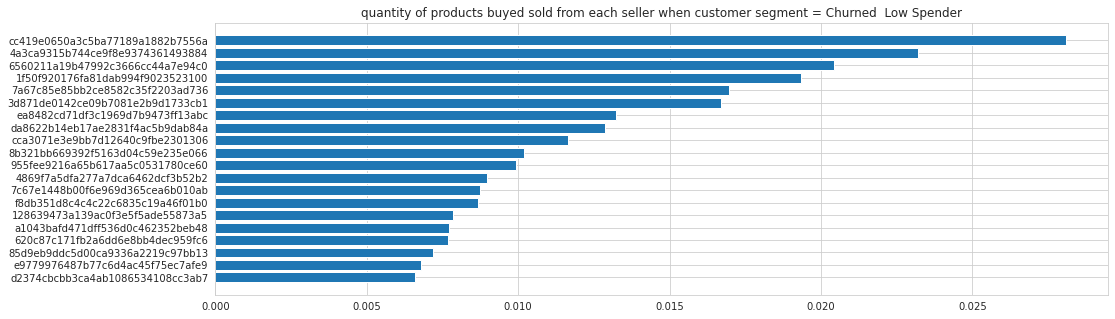

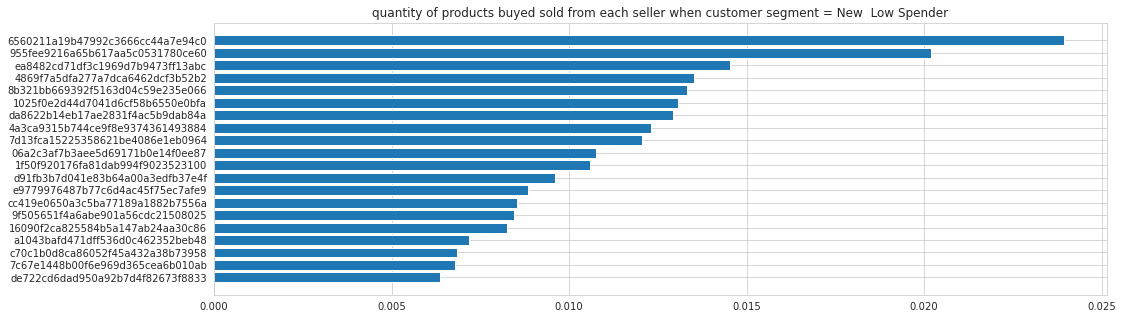

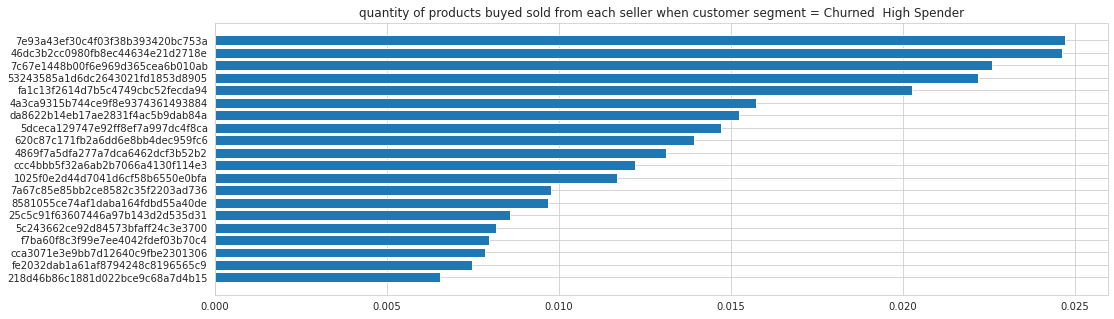

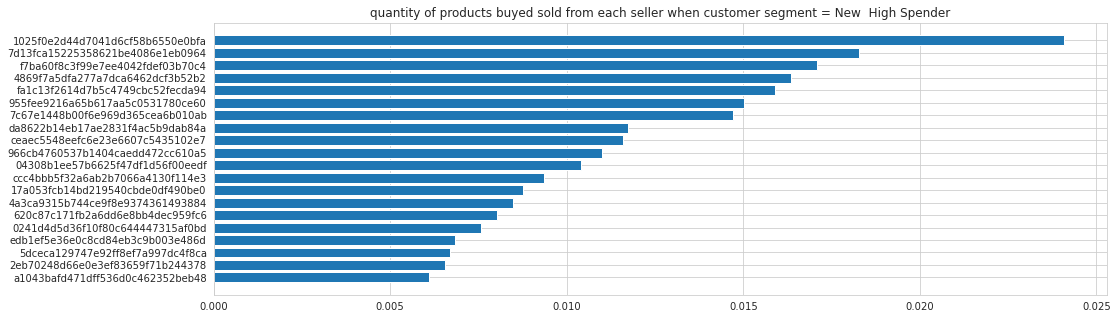

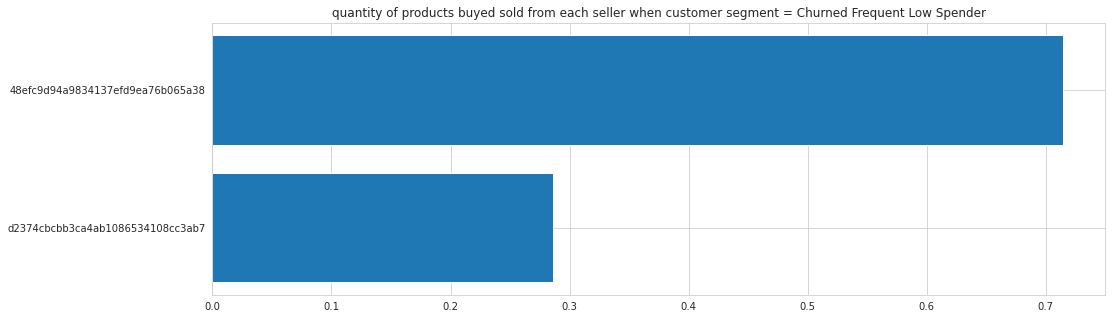

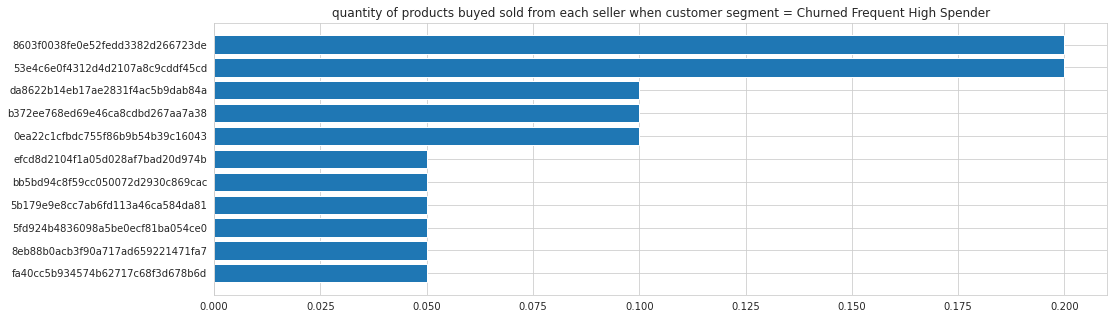

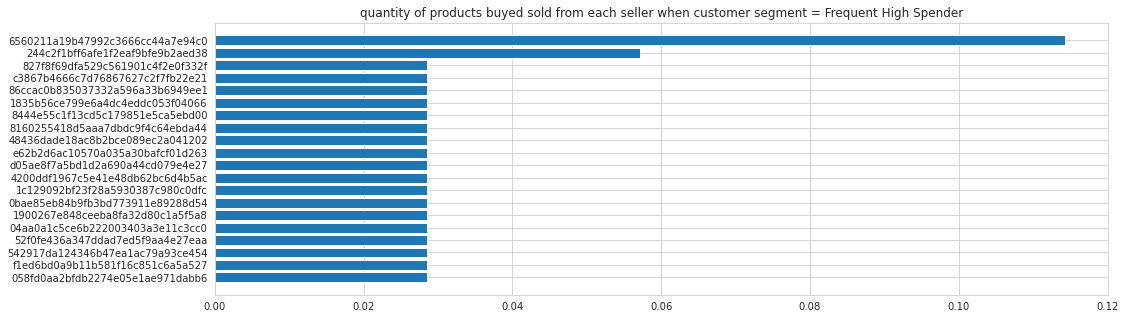

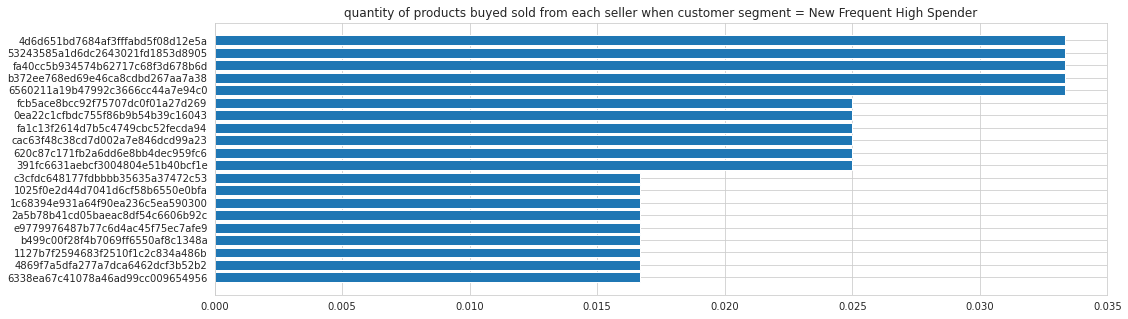

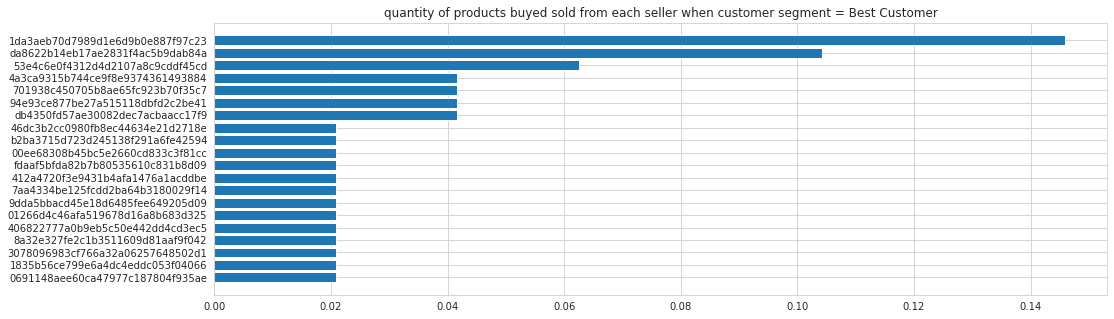

In [266]:
top10_sellers = {}
for segment in dfMerged_['rfm_segmentation'].unique():
    ser = dfMerged_[dfMerged_['rfm_segmentation']==segment].drop_duplicates(subset=['order_id'])['seller_id'].value_counts(normalize=True).head(20)
    top10_sellers[segment] = ser
    plt.figure(figsize=(16,5))
    plt.barh(ser.index,ser.values)
    plt.gca().invert_yaxis()
    plt.title('quantity of products buyed sold from each seller when customer segment = {}'.format(segment))
    plt.show()

In [267]:
topSellers = []
for val in top10_sellers.values():
    for item in val.index:
        topSellers.append(item)
topSellers = list(set(topSellers))
print(dfMerged_['seller_id'].nunique())
len(topSellers)

3091


102

In [268]:
dfMerged_[dfMerged_['seller_id'].isin(topSellers)]['rfm_segmentation'].value_counts().to_frame().join(dfMerged_['rfm_segmentation'].value_counts(),lsuffix=': topSellers',rsuffix=': allSellers')

,rfm_segmentation: topSellers,rfm_segmentation: allSellers
Churned Low Spender,21103,55237
New Low Spender,12438,36649
Churned High Spender,6194,15826
New High Spender,3558,10359
New Frequent High Spender,109,183
Best Customer,47,66
Frequent High Spender,37,47
Churned Frequent High Spender,25,25
Churned Frequent Low Spender,14,14


In [269]:
dfMerged_[dfMerged_['seller_id'].isin(topSellers)].drop_duplicates(subset=['seller_id'])['rfm_segmentation'].value_counts().to_frame().join(dfMerged_['rfm_segmentation'].value_counts(),lsuffix=': topSellers',rsuffix=': allSellers')

,rfm_segmentation: topSellers,rfm_segmentation: allSellers
Churned Low Spender,69,55237
Churned High Spender,27,15826
Best Customer,2,66
New Low Spender,2,36649
Churned Frequent High Spender,1,25
New High Spender,1,10359


In [270]:
dfMerged_[dfMerged_['seller_id'].isin(topSellers)]['product_category_name'].value_counts().to_frame().join(dfMerged_['product_category_name'].value_counts(),lsuffix=': topSellers',rsuffix=': allSellers')

,product_category_name: topSellers,product_category_name: allSellers
bed_bath_table,6420,11990
watches_gifts,4714,6213
health_beauty,3927,10030
furniture_decor,3680,8833
garden_tools,2715,4590
sports_leisure,2393,9005
computers_accessories,2289,8149
cool_stuff,1900,3998
telephony,1685,4726
perfumery,1615,3587


In [271]:
value_counts = pd.DataFrame({'all':dfMerged_['rfm_segmentation'].value_counts(),
            'watches_gifts, office_furniture, & home_confort':dfMerged_[dfMerged_['product_category_name'].isin(['watches_gifts','office_furniture','home_confort'])]['rfm_segmentation'].value_counts(),
            'watches_gifts':dfMerged_[dfMerged_['product_category_name']=='watches_gifts']['rfm_segmentation'].value_counts(),
            'office_furniture':dfMerged_[dfMerged_['product_category_name']=='office_furniture']['rfm_segmentation'].value_counts(),
            'home_confort':dfMerged_[dfMerged_['product_category_name']=='home_confort']['rfm_segmentation'].value_counts(),
             })
value_counts.fillna(0,inplace=True)
for col in value_counts.columns:
    value_counts.loc['sum',col] = value_counts[col].sum()
    value_counts[col] = value_counts[col].astype(int)
value_counts

,all,"watches_gifts, office_furniture, & home_confort",watches_gifts,office_furniture,home_confort
Best Customer,66,3,3,0,0
Churned High Spender,15826,1678,943,618,117
Churned Low Spender,55237,2917,2152,539,226
Churned Frequent High Spender,25,0,0,0,0
Churned Frequent Low Spender,14,0,0,0,0
Frequent High Spender,47,5,5,0,0
New High Spender,10359,1232,823,361,48
New Low Spender,36649,2628,2271,270,87
New Frequent High Spender,183,16,16,0,0
sum,118406,8479,6213,1788,478


In [272]:
dfMerged_['product_category_name'].nunique()

73

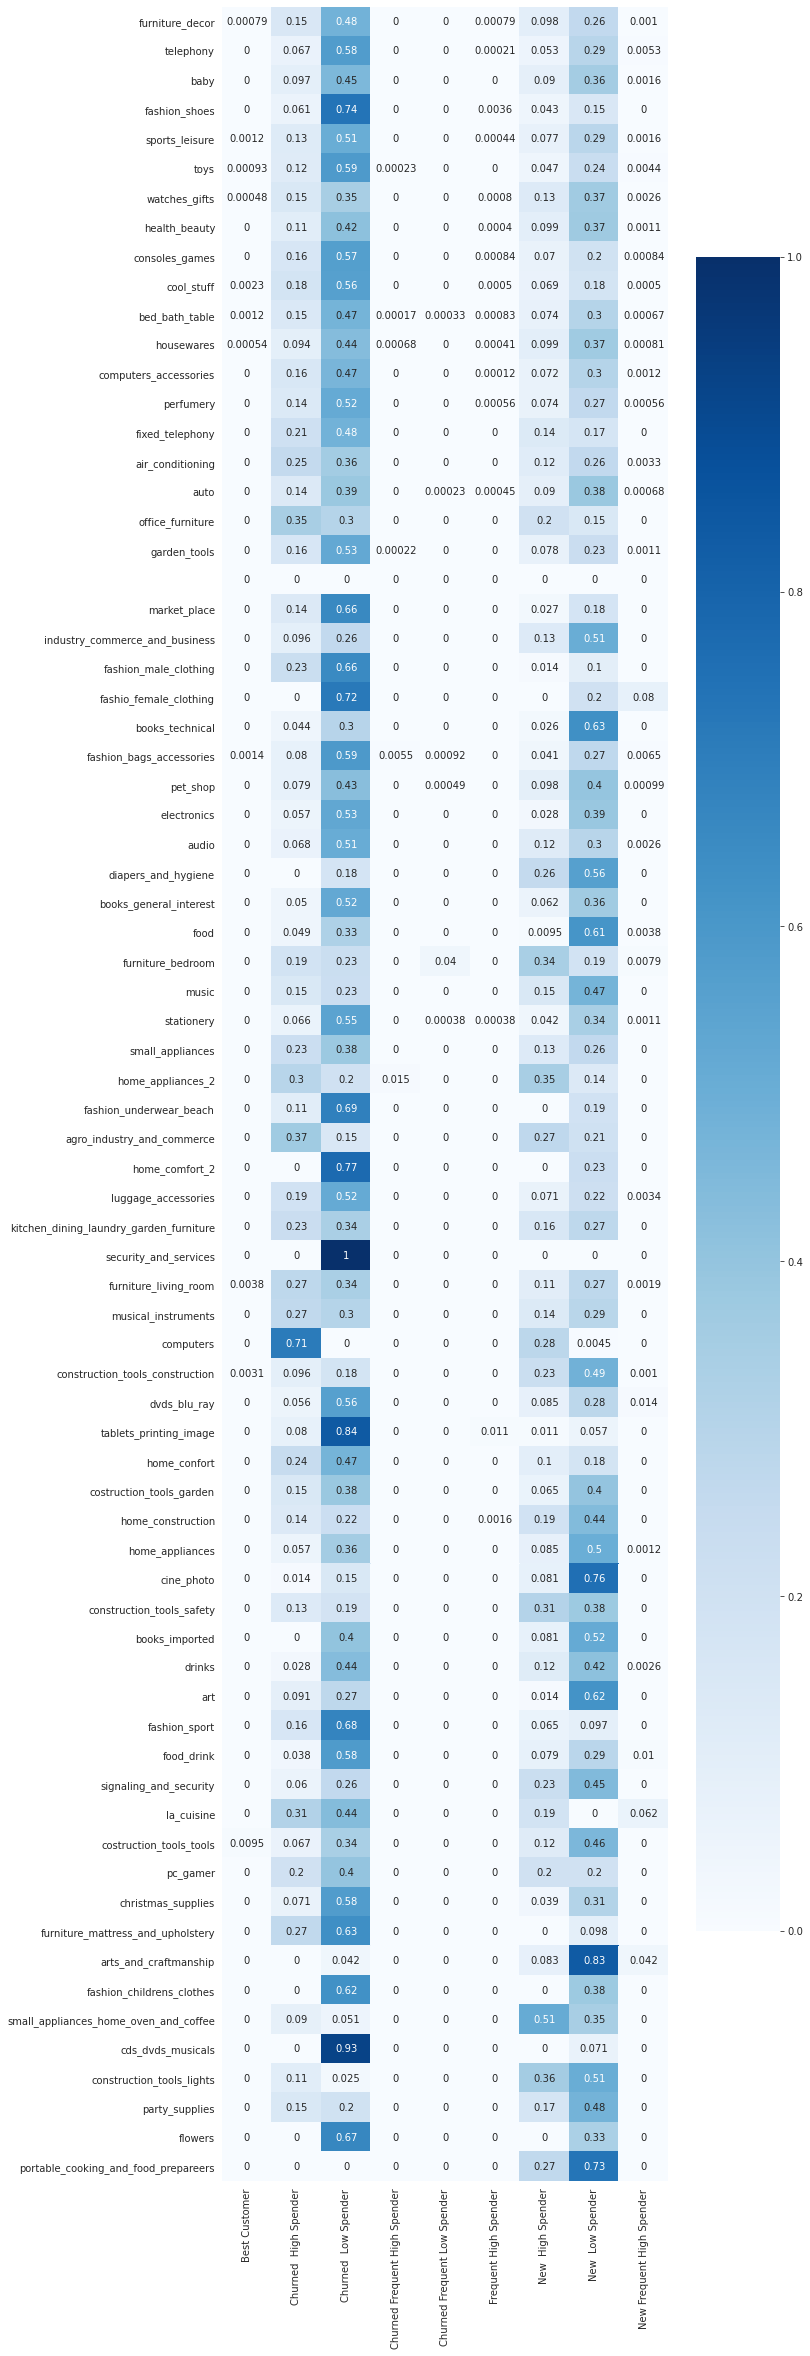

In [273]:
df = dfMerged_['rfm_segmentation'].value_counts().to_frame().sort_index()
df.columns = ['all']
for product in dfMerged_['product_category_name'].unique():
    ser = dfMerged_[dfMerged_['product_category_name']==product]['rfm_segmentation'].value_counts(normalize=True).to_frame()
    ser.columns = [product]
    df = df.join(ser)
df.fillna(0,inplace=True)
plt.figure(figsize=(10,40))
sns.heatmap(df[[col for col in df.columns if col != 'all']].T,annot=True, fmt = '.2g', cbar=True,cmap='Blues')
plt.show()

In [274]:
df.head()

,all,furniture_decor,telephony,baby,fashion_shoes,sports_leisure,toys,watches_gifts,health_beauty,consoles_games,cool_stuff,bed_bath_table,housewares,computers_accessories,perfumery,fixed_telephony,air_conditioning,auto,office_furniture,garden_tools,NaN,market_place,industry_commerce_and_business,fashion_male_clothing,fashio_female_clothing,books_technical,fashion_bags_accessories,pet_shop,electronics,audio,diapers_and_hygiene,books_general_interest,food,furniture_bedroom,music,stationery,small_appliances,home_appliances_2,fashion_underwear_beach,agro_industry_and_commerce,home_comfort_2,luggage_accessories,kitchen_dining_laundry_garden_furniture,security_and_services,furniture_living_room,musical_instruments,computers,construction_tools_construction,dvds_blu_ray,tablets_printing_image,home_confort,costruction_tools_garden,home_construction,home_appliances,cine_photo,construction_tools_safety,books_imported,drinks,art,fashion_sport,food_drink,signaling_and_security,la_cuisine,costruction_tools_tools,pc_gamer,christmas_supplies,furniture_mattress_and_upholstery,arts_and_craftmanship,fashion_childrens_clothes,small_appliances_home_oven_and_coffee,cds_dvds_musicals,construction_tools_lights,party_supplies,flowers,portable_cooking_and_food_prepareers
Best Customer,66,0.000792,0.000000,0.000000,0.000000,0.001222,0.000934,0.000483,0.000000,0.000000,0.002251,0.001168,0.000542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.001382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.003759,0.000000,0.000000,0.003141,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.009524,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Churned High Spender,15826,0.153062,0.066653,0.096502,0.061151,0.126374,0.123336,0.151779,0.109771,0.161074,0.182341,0.145955,0.094186,0.157811,0.142738,0.209559,0.254967,0.138213,0.345638,0.162092,0.0,0.138554,0.095588,0.227586,0.00,0.044118,0.080184,0.078818,0.056922,0.068241,0.000000,0.049558,0.049430,0.190476,0.150,0.066286,0.225532,0.295203,0.111111,0.369048,0.000000,0.192605,0.230769,0.0,0.274436,0.267038,0.713636,0.096335,0.056338,0.08046,0.244770,0.149798,0.138583,0.056901,0.013514,0.130653,0.000000,0.028205,0.091324,0.161290,0.037801,0.059701,0.3125,0.066667,0.2,0.070968,0.268293,0.000000,0.000,0.089744,0.000000,0.111465,0.152174,0.000000,0.0
Churned Low Spender,55237,0.482282,0.580618,0.453154,0.737410,0.505941,0.586312,0.346371,0.416750,0.568792,0.563032,0.472894,0.435967,0.465210,0.517145,0.481618,0.360927,0.386451,0.301454,0.525054,0.0,0.656627,0.264706,0.655172,0.72,0.297794,0.593548,0.426108,0.527758,0.509186,0.179487,0.523894,0.325095,0.230159,0.225,0.548952,0.380142,0.202952,0.694444,0.154762,0.774194,0.515907,0.337793,1.0,0.338346,0.304590,0.000000,0.183246,0.563380,0.83908,0.472803,0.384615,0.223622,0.355932,0.148649,0.185930,0.403226,0.435897,0.273973,0.677419,0.584192,0.263682,0.4375,0.342857,0.4,0.580645,0.634146,0.041667,0.625,0.051282,0.928571,0.025478,0.195652,0.666667,0.0
Churned Frequent High Spender,25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000234,0.000000,0.000000,0.000000,0.000000,0.000167,0.000678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000218,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.005530,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.014760,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Churned Frequent Low Spender,14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [275]:
dfMerged_.groupby('rfm_segmentation').agg({
    'payment_value':['sum','count','mean','std'], 
    'freight_value':['sum','mean','std'], 
    'price':['sum','mean','std'], 
    'order_item_id':['mean','max','std'], 
    'payment_sequential':['mean','max','std'], 
    'payment_installments':['mean','max','std']
})

payment_value                                 \
                                        sum  count        mean         std   
rfm_segmentation                                                             
Best Customer                  8.716200e+03     66  132.063629   93.419441   
Churned  High Spender          6.424872e+06  15826  405.969421  504.119598   
Churned  Low Spender           5.626138e+06  55237  101.854523   58.087360   
Churned Frequent High Spender  3.852500e+03     25  154.100006  110.037521   
Churned Frequent Low Spender   3.160000e+02     14   22.571430    6.998915   
Frequent High Spender          6.638100e+03     47  141.236176  108.597565   
New  High Spender              4.480298e+06  10359  432.502899  449.150177   
New  Low Spender               3.831520e+06  36649  104.546387   58.615898   
New Frequent High Spender      5.414949e+04    183  295.898865  372.629852   

                              freight_value                            price  \
                                        sum       mean        std        sum   
rfm_segmentation                                                               
Best Customer                        1252.0  19.261538  10.738769     3861.0   
Churned  High Spender              430611.0  27.245239  24.309504  4397017.0   
Churned  Low Spender               908524.0  16.457277   8.139385  4042218.0   
Churned Frequent High Spender         569.0  22.760000  13.902278     2816.0   
Churned Frequent Low Spender          144.0  10.285714   3.750458      152.0   
Frequent High Spender                 640.0  13.913043   6.636016     4367.0   
New  High Spender                  326679.0  31.566238  30.155953  2991982.0   
New  Low Spender                   640967.0  17.506541  10.597860  2736928.0   
New Frequent High Spender            3811.0  20.825137  14.265228    21966.0   

                                                      order_item_id        \
                                     mean         std          mean   max   
rfm_segmentation                                                            
Best Customer                   59.400000   52.939175      1.415385   4.0   
Churned  High Spender          278.204176  322.687371      1.463714  20.0   
Churned  Low Spender            73.221955   50.160438      1.117363  21.0   
Churned Frequent High Spender  112.640000   93.720720      1.160000   2.0   
Churned Frequent Low Spender    10.857143    3.738719      1.000000   1.0   
Frequent High Spender           94.934783   98.404246      1.260870   4.0   
New  High Spender              289.108320  346.636554      1.492705  13.0   
New  Low Spender                74.752902   50.409086      1.114905  12.0   
New Frequent High Spender      120.032787  118.294608      1.497268   6.0   

                                        payment_sequential                \
                                    std               mean max       std   
rfm_segmentation                                                           
Best Customer                  0.788438           1.000000   1  0.000000   
Churned  High Spender          1.201809           1.419373  29  1.761581   
Churned  Low Spender           0.476051           1.026938   7  0.198294   
Churned Frequent High Spender  0.374166           1.080000   2  0.276887   
Churned Frequent Low Spender   0.000000           1.000000   1  0.000000   
Frequent High Spender          0.612274           1.021277   2  0.145865   
New  High Spender              1.105067           1.218071  15  0.894965   
New  Low Spender               0.436682           1.020574   6  0.164565   
New Frequent High Spender      1.098822           1.054645   3  0.271883   

                              payment_installments                
                                              mean max       std  
rfm_segmentation                                                  
Best Customer                             4.560606  21  4.995779  
Churned  High Spender     

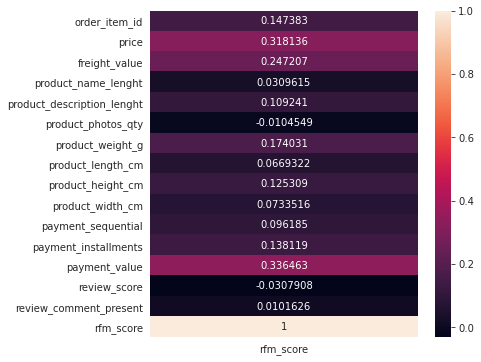

In [276]:
plt.figure(figsize=(6,6))
sns.heatmap(dfMerged_.corr()[['rfm_score']],annot=True,fmt='g')
plt.show()

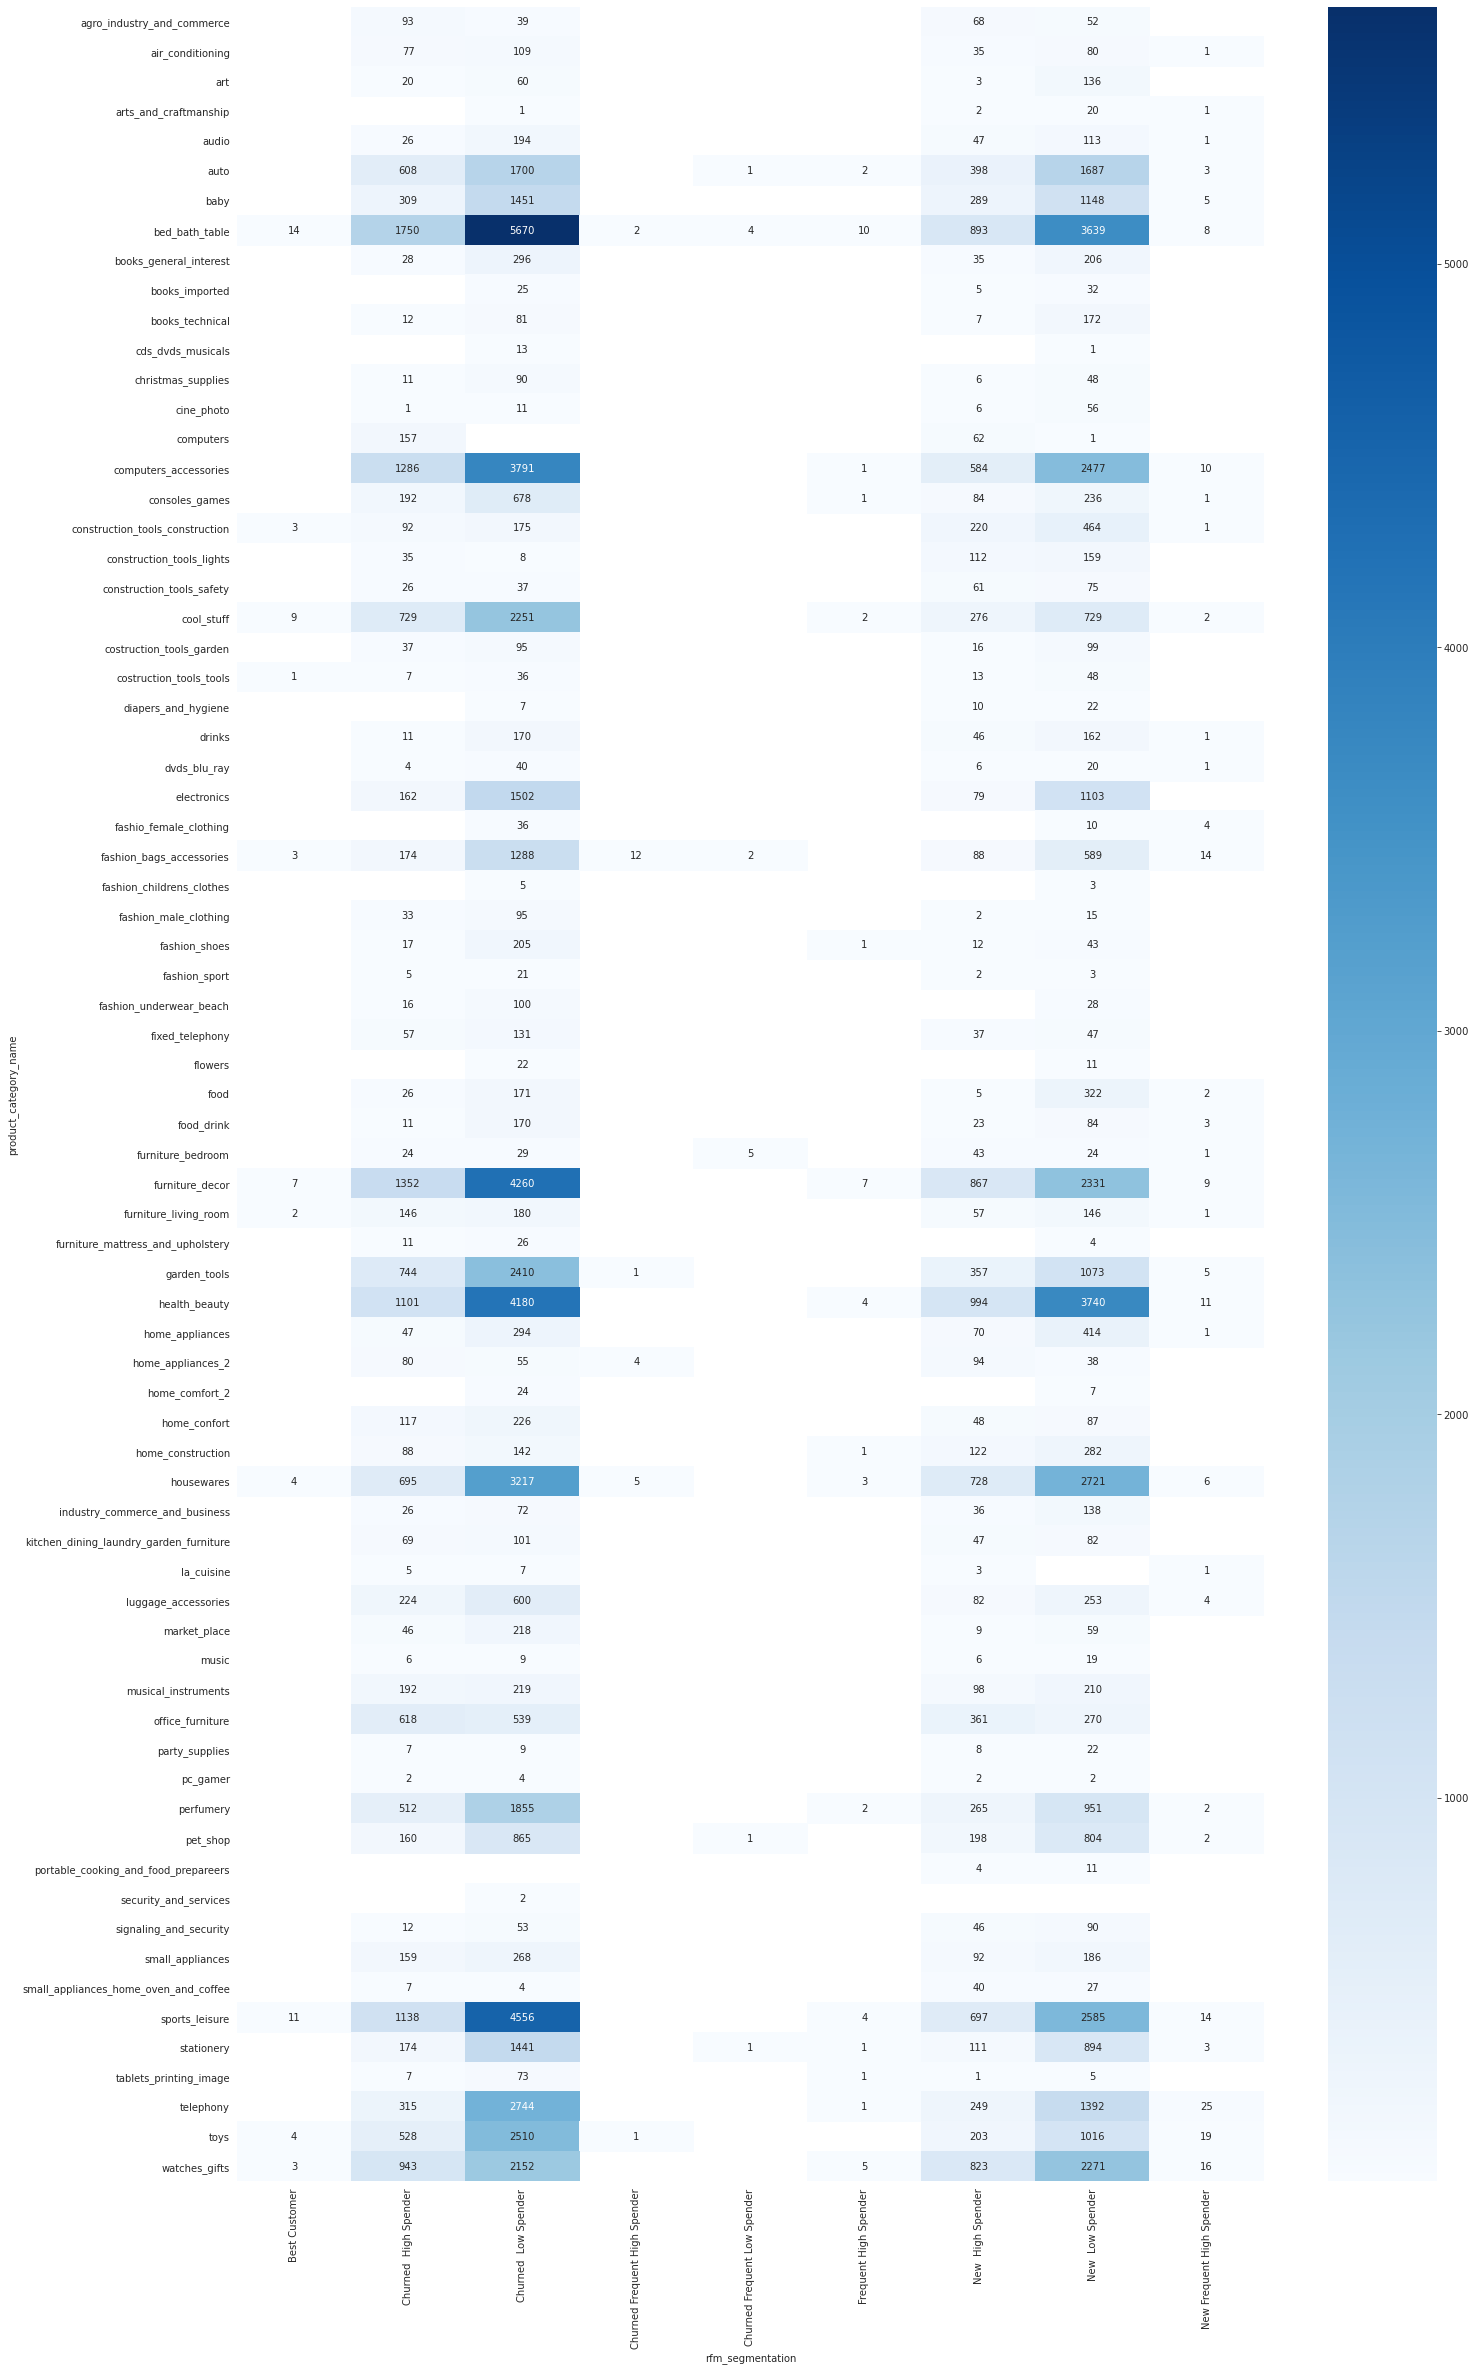

In [277]:
plt.figure(figsize=(23,40))
sns.heatmap((dfMerged_.groupby(['rfm_segmentation','product_category_name'])['rfm_score'].count().unstack()).T,annot=True,fmt='g',cmap='Blues')
plt.show()

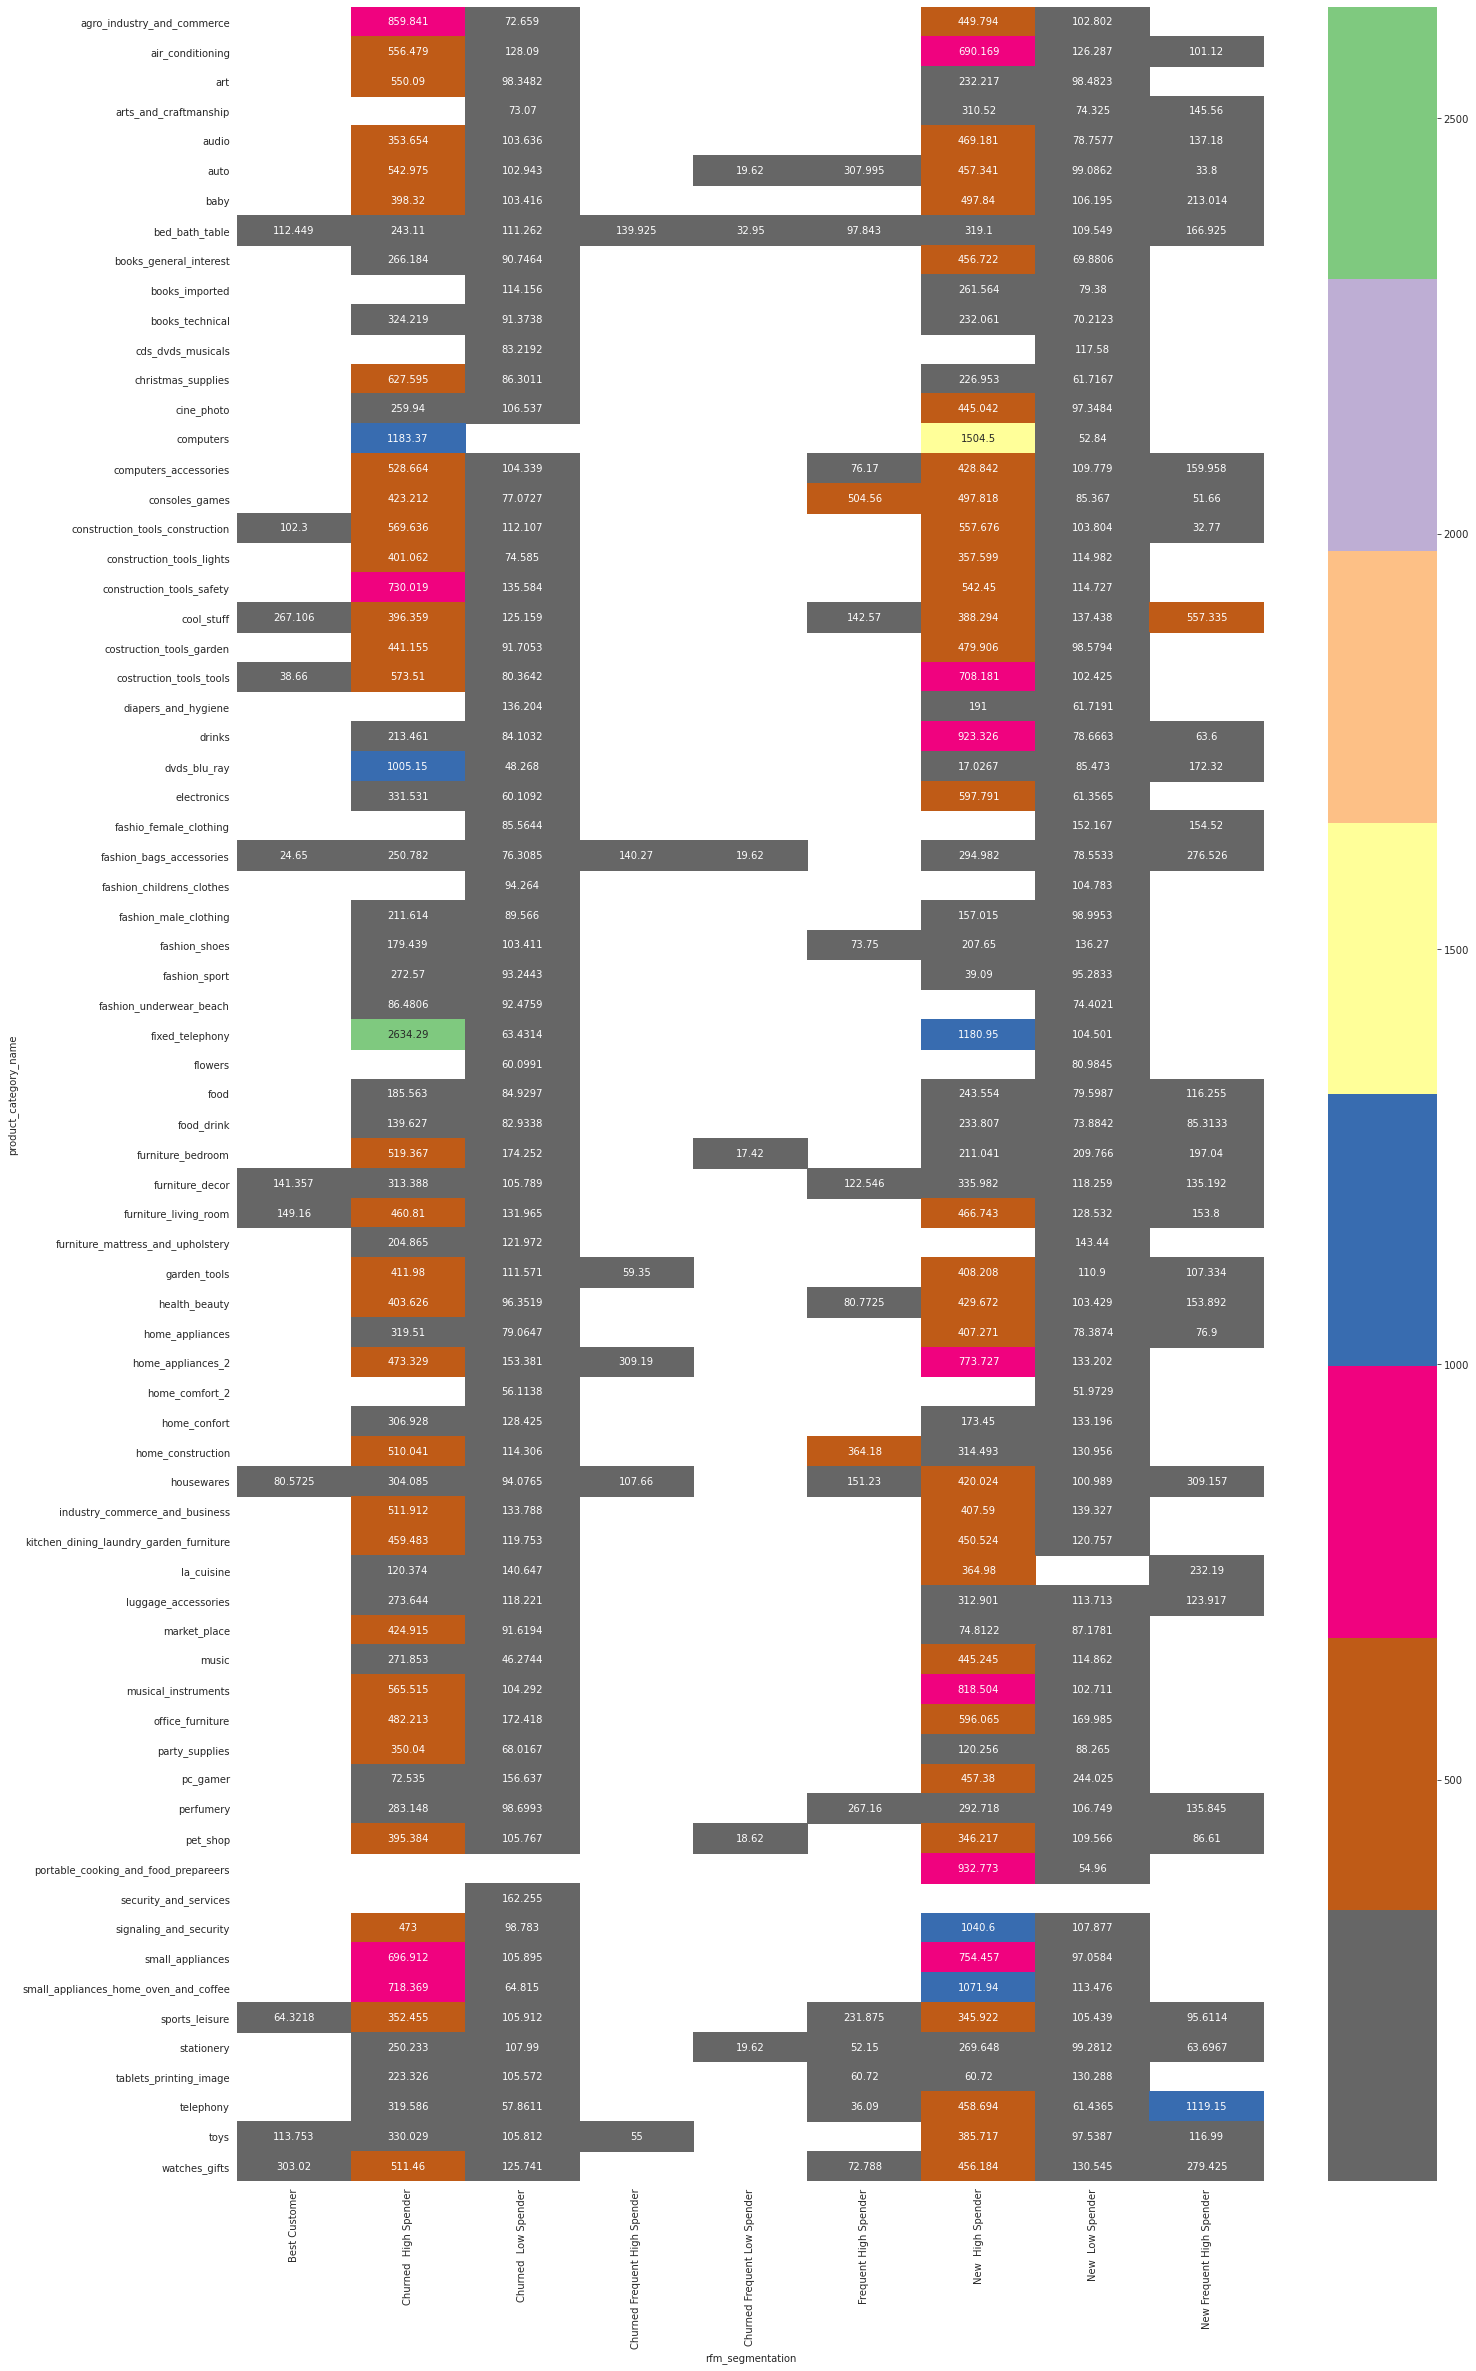

In [278]:
plt.figure(figsize=(23,40))
sns.heatmap((dfMerged_.groupby(['rfm_segmentation','product_category_name'])['payment_value'].mean().unstack()).T,annot=True,fmt='g',cmap='Accent_r')
plt.show()

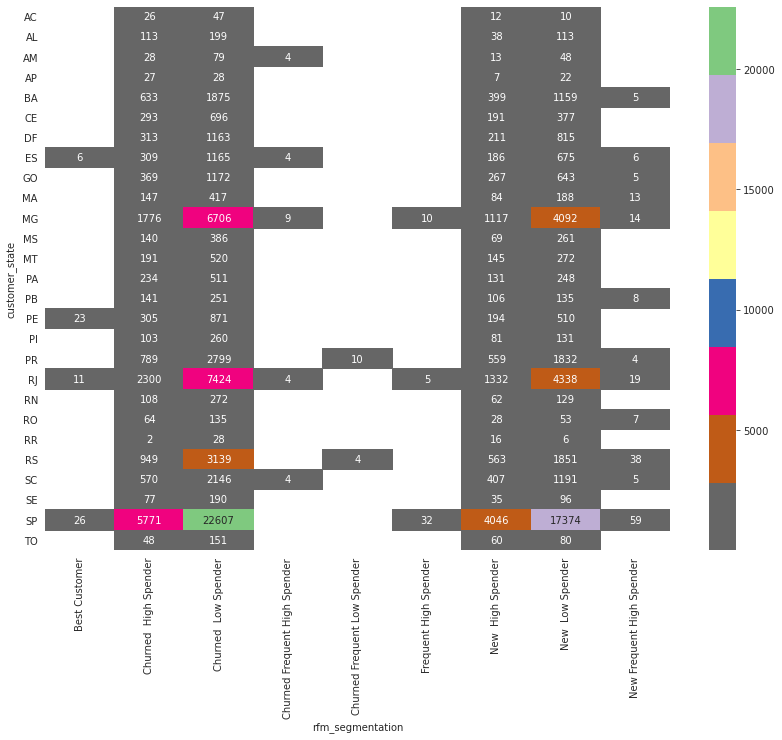

In [279]:
plt.figure(figsize=(14,10))
sns.heatmap((dfMerged_.groupby(['rfm_segmentation','customer_state'])['payment_value'].count().unstack()).T,annot=True,fmt='g',cmap='Accent_r')
plt.yticks(rotation=0)
plt.show()

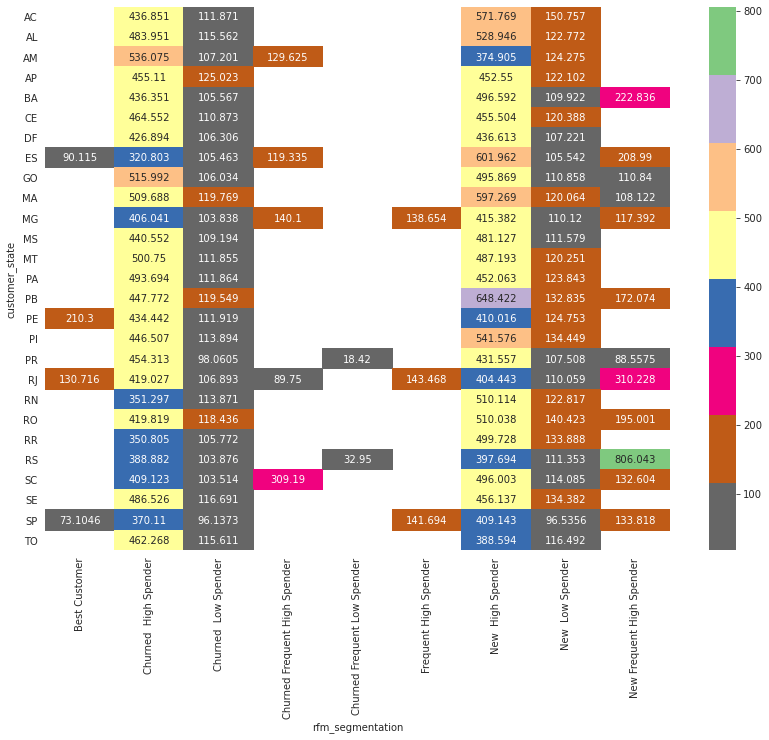

In [280]:
plt.figure(figsize=(14,10))
sns.heatmap((dfMerged_.groupby(['rfm_segmentation','customer_state'])['payment_value'].mean().unstack()).T,annot=True,fmt='g',cmap='Accent_r')
plt.yticks(rotation=0)
plt.show()

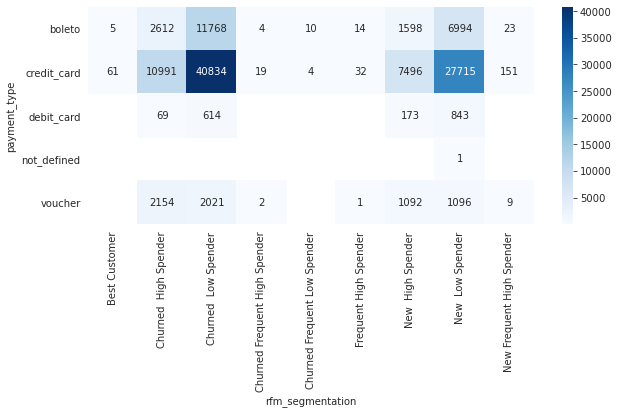

In [281]:
plt.figure(figsize=(10,4))
sns.heatmap((dfMerged_.groupby(['rfm_segmentation','payment_type'])['payment_value'].count().unstack()).T,annot=True,fmt='g',cmap='Blues')
plt.yticks(rotation=0)
plt.show()

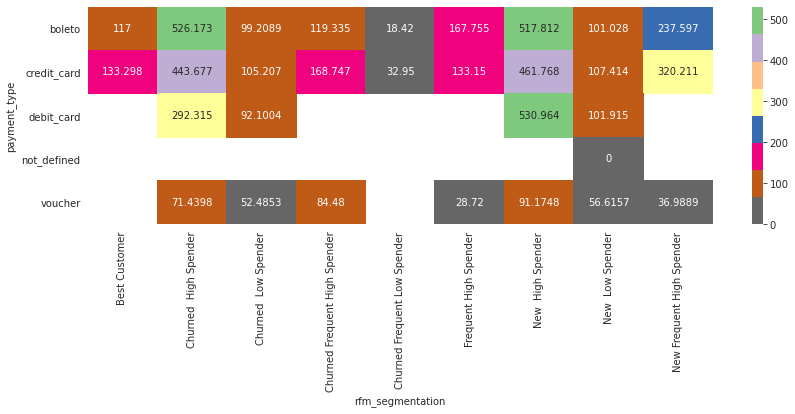

In [282]:
plt.figure(figsize=(14,4))
sns.heatmap((dfMerged_.groupby(['rfm_segmentation','payment_type'])['payment_value'].mean().unstack()).T,annot=True,fmt='g',cmap='Accent_r')
plt.yticks(rotation=0)
plt.show()

In [ ]:
import pickle
pickle.dump(dfMerged_,open('Merged_Data.pkl','wb'))
pickle.dump(dfRFM_0,open('RFM_Data.pkl','wb'))

In [ ]:
from IPython.display import FileLink
FileLink(r'Merged_Data.pkl')

In [ ]:
FileLink(r'RFM_Data.pkl')